This is the main file used to train and test the MaskRCNN.

As some cuda statements are hardcoded. This code will not run on CPU 

 # $\color{orange}{\text{Set paths}}$

In [1]:
# Mount drive if using colab 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
metric_path = 'drive/My Drive/02456_Deep_Learning_F20_DTU/02456_DL_project/GITHUB/02456DL/metrics'
image_path  = 'drive/My Drive/02456_Deep_Learning_F20_DTU/02456_DL_project/GITHUB/02456DL/data'
model_path  = 'drive/My Drive/02456_Deep_Learning_F20_DTU/02456_DL_project/GITHUB/02456DL/models/maskrcnn/'

 # $\color{orange}{\text{Imports}}$ 

 ## $\color{purple}{\text{Regular packages}}$

In [3]:
# Install autotime to see how long time it takes for a cell to run
!pip install ipython-autotime

In [4]:
# Notebook specific
%load_ext autotime
%matplotlib inline

# General
import random
import numpy as np
import pandas as pd
import os
import random

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.nn import Conv2d, MaxPool2d
from torch.nn.functional import relu
from torch.autograd import Variable


import torchvision # import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor 
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision.transforms as T


# Graph and image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.measure import label
import albumentations as A
from IPython.display import clear_output
from PIL import Image

time: 5.34 s (started: 2020-12-29 10:45:53 +00:00)


 ## $\color{purple}{\text{Packages needed for testing}}$

In [ ]:
# Install developer version of scikit image
#os.chdir("/content")
#!git clone https://github.com/scikit-image/scikit-image.git
#os.chdir("/content/scikit-image")
#!pip install -e .

# Force restart
#os._exit(0)

time: 809 µs


In [ ]:
# Check version is now 18
!pip show scikit-image

Name: scikit-image
Version: 0.16.2
Summary: Image processing routines for SciPy
Home-page: https://scikit-image.org
Author: None
Author-email: None
License: Modified BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: pillow, scipy, imageio, matplotlib, networkx, PyWavelets
Required-by: keras-vis, imgaug
time: 1.82 s


In [ ]:
# Import packages for test
from PIL import Image
from skimage.measure import label
from skimage.metrics import hausdorff_distance

# Wrap metrics around path to import it
os.chdir(metric_path)
from binary_metrics import BinaryImageMetrics
os.chdir("/content")

ImportError: ignored

time: 134 ms


 ## $\color{purple}{\text{Various small helper functions }}$

In [5]:
def tensor_to_binary(tensor):
    # we create a copy of the original tensor,
    # because of the way we are replacing them.
    res = tensor.clone()
    res[tensor >= 0.5] = 1
    res[tensor < 0.5] = 0
    return res

def to_cuda(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    # For maskRCNN
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

def get_masks(batch):
    return to_cuda(Variable(torch.from_numpy(batch['mask'])))

def get_input(batch):
    return {'x_img': to_cuda(Variable(torch.from_numpy(batch['images'])))}

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

time: 15.4 ms (started: 2020-12-29 10:46:02 +00:00)


 # $\color{orange}{\text{Load and process data}}$

 ## $\color{purple}{\text{Functions}}$

### 1. Loads all paths of images

In [6]:
def image_pathloader(image_path):
  
  # Set training and test data paths
  training_path = image_path + '/train'
  test_path = image_path + '/test'

  # Glob the training data and load a single image path
  training_paths = glob.glob(training_path + "/*.bmp")
  test_paths = glob.glob(test_path + "/*.bmp")
  print("The number of training images:", len(training_paths),"\n")
  print("The number of test images:", len(test_paths),"\n")

  # Nr traning images
  nr_train_images = int(len(training_paths)/2)

  # Get all training images
  training_paths_col = [0] * nr_train_images

  for i in range(0,nr_train_images,1):
    training_paths_col[i] = training_path + "/train_{}".format(i+1) + ".bmp"

  # Annonated paths
  training_paths_anno = [x.replace(".bmp","_anno.bmp") for x in training_paths_col]

  # Nr traning images

  nr_testA_images, nr_testB_images = 0, 0
  for i in test_paths:
    if str.find(i,"testA") > 0:
      nr_testA_images += 1
    else:
      nr_testB_images += 1

  # Test A
  testA_images_paths = [0] * int(nr_testA_images/2)

  for i in range(0,int(nr_testA_images/2),1):
    testA_images_paths[i] = test_path + "/testA_{}".format(i+1) + ".bmp"

  # Annonated paths
  testA_images_paths_anno = [x.replace(".bmp","_anno.bmp") for x in testA_images_paths]

  # Test B
  testB_images_paths = [0] * int(nr_testB_images/2)

  for i in range(0,int(nr_testB_images/2),1):
    testB_images_paths[i] = test_path + "/testB_{}".format(i+1) + ".bmp"

  # Annonated paths
  testB_images_paths_anno = [x.replace(".bmp","_anno.bmp") for x in testB_images_paths]

  test_paths_col = testA_images_paths + testB_images_paths

  test_paths_anno = testA_images_paths_anno + testB_images_paths_anno

  print("The number of colour training images:", len(training_paths_col),"\n")
  print("The number of annotated training images:", len(training_paths_anno),"\n")
  print("The number of colour test images:", len(test_paths_col),"\n")
  print("The number of annotated test images:", len(test_paths_anno),"\n")

  # Zipping training and test image and associated mask paths into a list of tuples with a corresponding idx for each image
  train = list(zip(list(range(0,85)), training_paths_col, training_paths_anno))
  test = list(zip(list(range(0,85)), test_paths_col, test_paths_anno))

  testA = list(zip(range(0,len(testA_images_paths)), testA_images_paths, testA_images_paths_anno))
  testB = list(zip(range(0,len(testB_images_paths)), testB_images_paths, testB_images_paths_anno))

  return train, testA, testB

time: 46.8 ms (started: 2020-12-29 10:46:08 +00:00)


### 2. Class that extracts the actual images 

In [7]:
class GlaSDataset_MaskRCNN(torch.utils.data.Dataset):

  def __init__(self, data, transforms = None, crop_scale = None):
        self.transforms = transforms
        self.crop_scale = crop_scale
        #self.train = train
        # load all image files, sorting them to
        # ensure that they are aligned
        unzip = list(zip(*data))
        self.idx = unzip[0]
        self.imgs = unzip[1]
        self.masks = unzip[2]

  def __getitem__(self, idx):
    img_path = self.imgs[idx]
    mask_path = self.masks[idx]
    img = Image.open(img_path).convert("RGB")
    img = np.array(img)
    mask = Image.open(mask_path)
    mask = np.array(mask)
    
    #obj_ids = np.unique(mask)
    #print("Before cropping:", obj_ids)

    # Data augmentation 
    if self.transforms is not None:
      img, mask = self.transforms(img, mask, self.crop_scale)

    # Get object id's
    obj_ids = np.unique(mask)[1:]
    #print("Obejct id's after cropping:", obj_ids)
    
    #split the labeled mask into a set of binary (boolean) masks of image size
    masks = mask == obj_ids[:, None, None]
    #print("masks shape:", masks.shape)
    #print("values in masks:", np.unique(masks))
    # a mask in masks is a binary array of size 1 x H x W with values True and False
    
    # get bounding box coordinates for each mask
    boxes = []
    idx_delete_masks = np.array([])
    # Get the number of objects
    num_objs = len(obj_ids)
    for i in range(num_objs):
      # Extract where the mask is located
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      tmp_diff_x = xmax - xmin
      tmp_diff_y = ymax - ymin
      if np.abs(tmp_diff_x) > 1 and np.abs(tmp_diff_y) > 1:
        boxes.append([xmin, ymin, xmax, ymax])
        # save index to be deleted if we do not enter here
      else:
        idx_delete_masks = np.append(idx_delete_masks, i) 

    #print("Number of boxes:", len(boxes))
    #print("index to delete:", idx_delete_masks)

    masks = np.delete(masks, idx_delete_masks.astype(int), axis = 0)

    # Update number of objects to be correct
    num_objs = len(boxes)
    
    #print("masks shape after deleting:", masks.shape)
          
    #to tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float64)

    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([idx])

    # Computes the area of each box
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks 
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    # Convert PIL-image to tensor of values 0-1 in format (C, H, W)  
    pipe = T.Compose([T.ToTensor()])    
    img = pipe(img)

    return img, target

  def __len__(self):
      return len(self.imgs)

time: 84 ms (started: 2020-12-29 10:46:08 +00:00)


### 3. Data augmentor function

In [8]:
def data_augmentor(img, mask, scale):

  """
  Takes an image and a mask and randomly flips it and crops it to some scaled (scale) size. 
  """

  # Compute aspect ratio
  img_aspect_ratio = img.shape[1] / img.shape[0]
  new_hieght = int(scale*img.shape[0])
  new_width = int(new_hieght*img_aspect_ratio)

  # Randomly flip and crop image and mask
  aug_pipeline = A.Compose([A.VerticalFlip(p = 0.5) , A.HorizontalFlip(p = 0.5), A.RandomCrop(height=new_hieght,width=new_width, p = 0.5)], p = 0.5)
  
  #Do augmentation
  aug = aug_pipeline(image = img, mask = mask)
  
  # Extract augmented sample
  img, mask = aug['image'], aug['mask']
  
  return img, mask

time: 9.71 ms (started: 2020-12-29 10:46:08 +00:00)


### 4. Import and load dependencies from the example: https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=DfPPQ6ztJhv4

In [9]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-8bc7v7kn
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-8bc7v7kn
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=265565 sha256=273d4d4682c2a46cf16fb5a4b4a10993babd28abd7c39493701f122a20565e24
  Stored in directory: /tmp/pip-ephem-wheel-cache-ki5et8ab/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


time: 11 s (started: 2020-12-29 10:46:08 +00:00)


In [10]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 12253 (delta 0), reused 1 (delta 0), pack-reused 12249
Receiving objects: 100% (12253/12253), 13.47 MiB | 22.95 MiB/s, done.
Resolving deltas: 100% (8546/8546), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


time: 1.73 s (started: 2020-12-29 10:46:19 +00:00)


In [11]:
from engine import train_one_epoch, evaluate
import utils

time: 19.6 ms (started: 2020-12-29 10:46:21 +00:00)


 ## $\color{purple}{\text{Execute}}$

In [12]:
# Load paths
train, testA, testB = image_pathloader(image_path)

# Get datasets
dataset_train = GlaSDataset_MaskRCNN(data = train, transforms = data_augmentor, crop_scale=0.8)
dataset_testA = GlaSDataset_MaskRCNN(data = testA, transforms = None, crop_scale=None)
dataset_testB = GlaSDataset_MaskRCNN(data = testB, transforms = None, crop_scale=None)

The number of training images: 170 

The number of test images: 160 

The number of colour training images: 85 

The number of annotated training images: 85 

The number of colour test images: 80 

The number of annotated test images: 80 

time: 2.89 s (started: 2020-12-29 10:46:21 +00:00)


 # $\color{orange}{\text{Load model}}$

 ## $\color{purple}{\text{Functions}}$

### 1. MaskRCNN model

In [13]:
def get_instance_segmentation_model(num_classes):
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # LOADING THE FASTERRCNN, bounding box prediction
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # LOADING THE MASKRCNN, mask prediction
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256 #Original: 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


# Number of classes is 2 as we only have foreground and background
num_classes = 2

time: 11.3 ms (started: 2020-12-29 10:46:24 +00:00)


 ## $\color{purple}{\text{Execute}}$

Check if GPU is available (NB - Code may not run on CPU due to hardcoded cuda statements)

In [14]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
# Define device 
device = torch.device('cuda') if use_cuda else torch.device('cpu')

Running GPU.
time: 60.7 ms (started: 2020-12-29 10:46:25 +00:00)


### Load best

In [ ]:
model = get_instance_segmentation_model(num_classes)

if use_cuda:
  # move model to the right device
  model.to(device)
  model.load_state_dict(torch.load(model_path + "maskRCNN.pt"))
else:
  model.load_state_dict(torch.load(model_path + "maskRCNN.pt", map_location=torch.device('cpu')))

time: 1.08 s


### Load fresh

In [15]:
# Load mode and cast to GPU
model = get_instance_segmentation_model(num_classes)
if use_cuda:
  model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth



MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample):

 # $\color{orange}{\text{Train model}}$

## $\color{purple}{\text{Setting hyperparamters of the model}}$

In [ ]:
# Hyperparamters

b_size = 2        #original: 2
lr = 0.005        #original: 0.005
moment = 0.9      #original: 0.9
wd = 0.0005       #original: 0.0005
step_size = 10    #original: 3
gam = 0.9         #original: 0.1
num_epochs = 1000 #original: 10

time: 1.73 ms


## $\color{purple}{\text{Define Data Loaders for training and evaluation}}$

In [ ]:
# use our dataset and defined transformations
dataset_val = GlaSDataset_MaskRCNN(data = train, transforms = None, crop_scale=None)

# split the dataset in train and validation set
torch.manual_seed(1)
indices = torch.randperm(len(dataset_train)).tolist()

split = int(dataset_train.__len__() * 0.8)

dataset_train_ = torch.utils.data.Subset(dataset_train, indices[:split])
dataset_val_ = torch.utils.data.Subset(dataset_val, indices[split:])

data_loader_train = torch.utils.data.DataLoader(
    dataset_train_, batch_size=b_size, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val_, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

time: 9.42 ms


## $\color{purple}{\text{Construct optimizer, learning rate schedule and loss funciton}}$

In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, # before: 0.008, original: 0.005
                            momentum=moment, weight_decay=wd) #HYPERPARAMETERS before: 0.0005, original: 0.0005

# The learning rate scheduler did not contribute in anyway to better reesults.
# and a learning rate scheduler which decreases the learning rate by
# ne_lr = gamma * current_lr, step_size = frequency pr. decline (number of epochs)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=step_size,
                                               gamma=gam) #HYPERPARAMETERS

# Loss function to be used to evalute the validtion error on predicted masks 
criterion = torch.nn.BCEWithLogitsLoss()                                               

time: 6.05 ms


 ## $\color{purple}{\text{Execute}}$

### Training and hyperparameter tuning

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/17]  eta: 0:00:39  lr: 0.000317  loss: 7.2696 (7.2696)  loss_classifier: 0.7356 (0.7356)  loss_box_reg: 0.4743 (0.4743)  loss_mask: 5.1852 (5.1852)  loss_objectness: 0.7887 (0.7887)  loss_rpn_box_reg: 0.0857 (0.0857)  time: 2.3333  data: 0.9047  max mem: 9106
Epoch: [0]  [10/17]  eta: 0:00:10  lr: 0.003439  loss: 2.3967 (3.3502)  loss_classifier: 0.4275 (0.4952)  loss_box_reg: 0.5255 (0.5317)  loss_mask: 1.2011 (1.9475)  loss_objectness: 0.1585 (0.2977)  loss_rpn_box_reg: 0.0857 (0.0781)  time: 1.5345  data: 0.0942  max mem: 9106
Epoch: [0]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 2.0348 (2.7991)  loss_classifier: 0.4141 (0.4488)  loss_box_reg: 0.4985 (0.5351)  loss_mask: 0.7836 (1.4918)  loss_objectness: 0.1327 (0.2426)  loss_rpn_box_reg: 0.0857 (0.0808)  time: 1.5212  data: 0.0668  max mem: 9106
Epoch: [0] Total time: 0:00:25 (1.5273 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6930830443606657


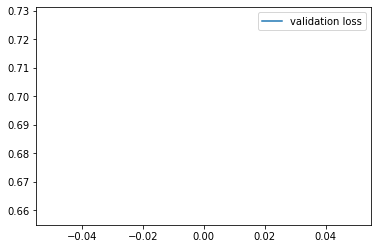

BEST VALIDATION ERROR THIS SESSION:  0.6930830443606657
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [1]  [ 0/17]  eta: 0:00:39  lr: 0.005000  loss: 1.6217 (1.6217)  loss_classifier: 0.3271 (0.3271)  loss_box_reg: 0.4870 (0.4870)  loss_mask: 0.6770 (0.6770)  loss_objectness: 0.0938 (0.0938)  loss_rpn_box_reg: 0.0369 (0.0369)  time: 2.2991  data: 0.8073  max mem: 9106
Epoch: [1]  [10/17]  eta: 0:00:10  lr: 0.005000  loss: 1.8071 (1.7902)  loss_classifier: 0.3668 (0.3490)  loss_box_reg: 0.5538 (0.4982)  loss_mask: 0.6517 (0.6764)  loss_objectness: 0.1493 (0.1757)  loss_rpn_box_reg: 0.0831 (0.0909)  time: 1.5481  data: 0.0849  max mem: 9106
Epoch: [1]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 1.8799 (1.8060)  loss_classifier: 0.3833 (0.3542)  loss_box_reg: 0.5813 (0.5308)  loss_mask: 0.6517 (0.6669)  loss_objectness: 0.1468 (0.1685)  loss_rpn_box_reg: 0.0771 (0.0856)  time: 1.5135  data: 0.0613  max mem: 9106
Epoch: [1] Total time: 0:00:25 (1.5192 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6924772227511686


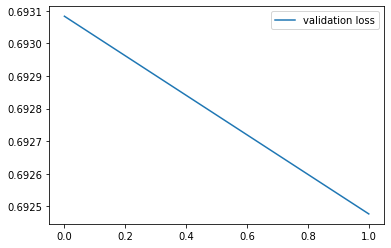

BEST VALIDATION ERROR THIS SESSION:  0.6924772227511686
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [2]  [ 0/17]  eta: 0:00:44  lr: 0.005000  loss: 2.1097 (2.1097)  loss_classifier: 0.4817 (0.4817)  loss_box_reg: 0.7644 (0.7644)  loss_mask: 0.5914 (0.5914)  loss_objectness: 0.1624 (0.1624)  loss_rpn_box_reg: 0.1098 (0.1098)  time: 2.6225  data: 1.1043  max mem: 9106
Epoch: [2]  [10/17]  eta: 0:00:10  lr: 0.005000  loss: 1.7768 (1.7353)  loss_classifier: 0.3759 (0.3539)  loss_box_reg: 0.6569 (0.5959)  loss_mask: 0.5821 (0.5840)  loss_objectness: 0.0892 (0.1113)  loss_rpn_box_reg: 0.0956 (0.0902)  time: 1.5297  data: 0.1094  max mem: 9106
Epoch: [2]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 1.7087 (1.6922)  loss_classifier: 0.3587 (0.3496)  loss_box_reg: 0.6569 (0.5955)  loss_mask: 0.5634 (0.5685)  loss_objectness: 0.0796 (0.0975)  loss_rpn_box_reg: 0.0857 (0.0811)  time: 1.5006  data: 0.0763  max mem: 9106
Epoch: [2] Total time: 0:00:25 (1.5067 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6900884053286385


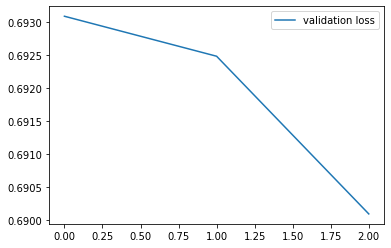

BEST VALIDATION ERROR THIS SESSION:  0.6900884053286385
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [3]  [ 0/17]  eta: 0:00:39  lr: 0.005000  loss: 1.9114 (1.9114)  loss_classifier: 0.3957 (0.3957)  loss_box_reg: 0.8383 (0.8383)  loss_mask: 0.5364 (0.5364)  loss_objectness: 0.0935 (0.0935)  loss_rpn_box_reg: 0.0475 (0.0475)  time: 2.3353  data: 0.7276  max mem: 9106
Epoch: [3]  [10/17]  eta: 0:00:10  lr: 0.005000  loss: 1.4759 (1.5109)  loss_classifier: 0.3287 (0.3312)  loss_box_reg: 0.5854 (0.5989)  loss_mask: 0.4510 (0.4493)  loss_objectness: 0.0627 (0.0694)  loss_rpn_box_reg: 0.0557 (0.0621)  time: 1.5596  data: 0.0794  max mem: 9106
Epoch: [3]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 1.4513 (1.4660)  loss_classifier: 0.3101 (0.3065)  loss_box_reg: 0.5390 (0.5590)  loss_mask: 0.4510 (0.4523)  loss_objectness: 0.0602 (0.0767)  loss_rpn_box_reg: 0.0557 (0.0715)  time: 1.5351  data: 0.0568  max mem: 9174
Epoch: [3] Total time: 0:00:26 (1.5408 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6897492864552666


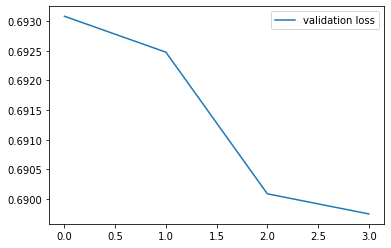

BEST VALIDATION ERROR THIS SESSION:  0.6897492864552666
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [4]  [ 0/17]  eta: 0:00:39  lr: 0.005000  loss: 1.3786 (1.3786)  loss_classifier: 0.2896 (0.2896)  loss_box_reg: 0.4639 (0.4639)  loss_mask: 0.4830 (0.4830)  loss_objectness: 0.0587 (0.0587)  loss_rpn_box_reg: 0.0834 (0.0834)  time: 2.3276  data: 0.7983  max mem: 9174
Epoch: [4]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 1.2743 (1.2797)  loss_classifier: 0.2719 (0.2683)  loss_box_reg: 0.4537 (0.4644)  loss_mask: 0.4346 (0.4132)  loss_objectness: 0.0606 (0.0687)  loss_rpn_box_reg: 0.0742 (0.0652)  time: 1.5782  data: 0.0865  max mem: 9174
Epoch: [4]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 1.2026 (1.2174)  loss_classifier: 0.2551 (0.2541)  loss_box_reg: 0.4484 (0.4398)  loss_mask: 0.3930 (0.4011)  loss_objectness: 0.0585 (0.0619)  loss_rpn_box_reg: 0.0577 (0.0605)  time: 1.5419  data: 0.0615  max mem: 9174
Epoch: [4] Total time: 0:00:26 (1.5481 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.684042800875271


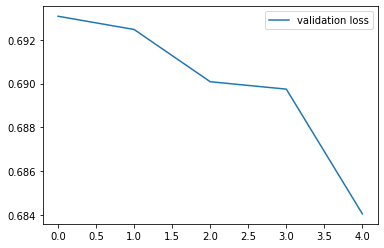

BEST VALIDATION ERROR THIS SESSION:  0.684042800875271
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [5]  [ 0/17]  eta: 0:00:38  lr: 0.005000  loss: 0.8397 (0.8397)  loss_classifier: 0.1706 (0.1706)  loss_box_reg: 0.2860 (0.2860)  loss_mask: 0.3174 (0.3174)  loss_objectness: 0.0405 (0.0405)  loss_rpn_box_reg: 0.0252 (0.0252)  time: 2.2680  data: 0.8235  max mem: 9174
Epoch: [5]  [10/17]  eta: 0:00:10  lr: 0.005000  loss: 1.0813 (1.0948)  loss_classifier: 0.2225 (0.2330)  loss_box_reg: 0.4060 (0.4152)  loss_mask: 0.3423 (0.3524)  loss_objectness: 0.0410 (0.0411)  loss_rpn_box_reg: 0.0403 (0.0530)  time: 1.5598  data: 0.0872  max mem: 9174
Epoch: [5]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 1.0088 (1.0343)  loss_classifier: 0.2164 (0.2199)  loss_box_reg: 0.3908 (0.3896)  loss_mask: 0.3174 (0.3312)  loss_objectness: 0.0405 (0.0406)  loss_rpn_box_reg: 0.0466 (0.0530)  time: 1.5373  data: 0.0620  max mem: 9174
Epoch: [5] Total time: 0:00:26 (1.5431 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6874395363471087


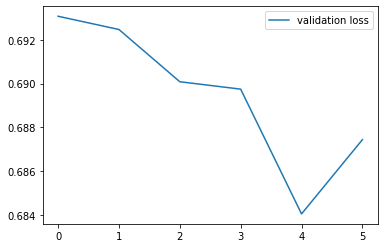

BEST VALIDATION ERROR THIS SESSION:  0.684042800875271
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [6]  [ 0/17]  eta: 0:00:39  lr: 0.005000  loss: 0.8724 (0.8724)  loss_classifier: 0.1729 (0.1729)  loss_box_reg: 0.3534 (0.3534)  loss_mask: 0.2944 (0.2944)  loss_objectness: 0.0284 (0.0284)  loss_rpn_box_reg: 0.0234 (0.0234)  time: 2.3018  data: 0.6900  max mem: 9174
Epoch: [6]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.8845 (0.8945)  loss_classifier: 0.1880 (0.1938)  loss_box_reg: 0.3534 (0.3393)  loss_mask: 0.2906 (0.2790)  loss_objectness: 0.0291 (0.0336)  loss_rpn_box_reg: 0.0384 (0.0489)  time: 1.5888  data: 0.0763  max mem: 9174
Epoch: [6]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.9032 (0.9539)  loss_classifier: 0.1956 (0.2055)  loss_box_reg: 0.3513 (0.3593)  loss_mask: 0.2914 (0.3000)  loss_objectness: 0.0419 (0.0387)  loss_rpn_box_reg: 0.0407 (0.0503)  time: 1.5620  data: 0.0550  max mem: 9174
Epoch: [6] Total time: 0:00:26 (1.5678 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6809316733304192


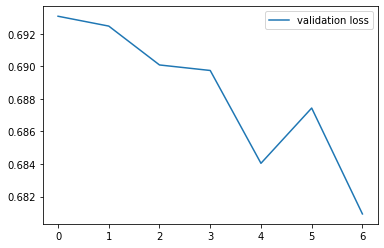

BEST VALIDATION ERROR THIS SESSION:  0.6809316733304192
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [7]  [ 0/17]  eta: 0:00:43  lr: 0.005000  loss: 0.7013 (0.7013)  loss_classifier: 0.1805 (0.1805)  loss_box_reg: 0.2415 (0.2415)  loss_mask: 0.1883 (0.1883)  loss_objectness: 0.0193 (0.0193)  loss_rpn_box_reg: 0.0716 (0.0716)  time: 2.5789  data: 1.0381  max mem: 9174
Epoch: [7]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.8713 (0.8742)  loss_classifier: 0.1886 (0.1809)  loss_box_reg: 0.3426 (0.3250)  loss_mask: 0.2632 (0.2753)  loss_objectness: 0.0320 (0.0418)  loss_rpn_box_reg: 0.0507 (0.0511)  time: 1.6078  data: 0.1037  max mem: 9174
Epoch: [7]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.8713 (0.9078)  loss_classifier: 0.1926 (0.1881)  loss_box_reg: 0.3472 (0.3387)  loss_mask: 0.2688 (0.2770)  loss_objectness: 0.0320 (0.0473)  loss_rpn_box_reg: 0.0447 (0.0566)  time: 1.5739  data: 0.0727  max mem: 9174
Epoch: [7] Total time: 0:00:26 (1.5795 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6829463243484497


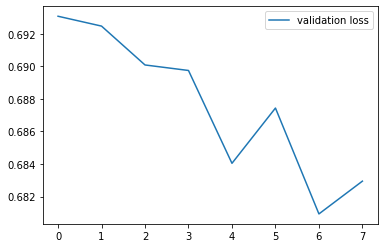

BEST VALIDATION ERROR THIS SESSION:  0.6809316733304192
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [8]  [ 0/17]  eta: 0:00:36  lr: 0.005000  loss: 0.5205 (0.5205)  loss_classifier: 0.0867 (0.0867)  loss_box_reg: 0.1595 (0.1595)  loss_mask: 0.2234 (0.2234)  loss_objectness: 0.0177 (0.0177)  loss_rpn_box_reg: 0.0331 (0.0331)  time: 2.1643  data: 0.7049  max mem: 9174
Epoch: [8]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.7063 (0.7709)  loss_classifier: 0.1742 (0.1723)  loss_box_reg: 0.2943 (0.2970)  loss_mask: 0.2175 (0.2406)  loss_objectness: 0.0233 (0.0273)  loss_rpn_box_reg: 0.0339 (0.0336)  time: 1.5802  data: 0.0775  max mem: 9174
Epoch: [8]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.7172 (0.7943)  loss_classifier: 0.1752 (0.1764)  loss_box_reg: 0.2885 (0.2994)  loss_mask: 0.2234 (0.2498)  loss_objectness: 0.0252 (0.0309)  loss_rpn_box_reg: 0.0383 (0.0378)  time: 1.5600  data: 0.0560  max mem: 9174
Epoch: [8] Total time: 0:00:26 (1.5658 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6811616490868961


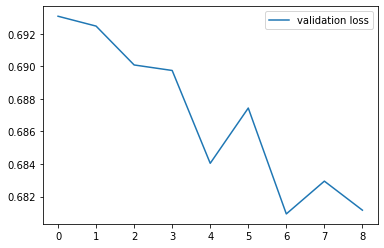

BEST VALIDATION ERROR THIS SESSION:  0.6809316733304192
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [9]  [ 0/17]  eta: 0:00:41  lr: 0.005000  loss: 0.8093 (0.8093)  loss_classifier: 0.1515 (0.1515)  loss_box_reg: 0.3164 (0.3164)  loss_mask: 0.2863 (0.2863)  loss_objectness: 0.0218 (0.0218)  loss_rpn_box_reg: 0.0333 (0.0333)  time: 2.4520  data: 0.8676  max mem: 9174
Epoch: [9]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.8018 (0.7789)  loss_classifier: 0.1589 (0.1622)  loss_box_reg: 0.2819 (0.2803)  loss_mask: 0.2494 (0.2543)  loss_objectness: 0.0239 (0.0375)  loss_rpn_box_reg: 0.0333 (0.0445)  time: 1.5872  data: 0.0892  max mem: 9174
Epoch: [9]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.7381 (0.7370)  loss_classifier: 0.1589 (0.1547)  loss_box_reg: 0.2803 (0.2733)  loss_mask: 0.2292 (0.2358)  loss_objectness: 0.0239 (0.0326)  loss_rpn_box_reg: 0.0333 (0.0406)  time: 1.5742  data: 0.0644  max mem: 9174
Epoch: [9] Total time: 0:00:26 (1.5800 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6780775259522831


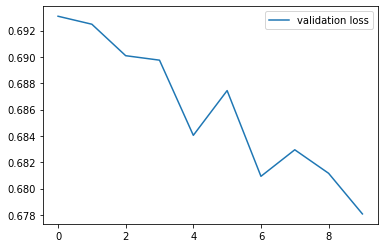

BEST VALIDATION ERROR THIS SESSION:  0.6780775259522831
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [10]  [ 0/17]  eta: 0:00:38  lr: 0.005000  loss: 0.8010 (0.8010)  loss_classifier: 0.1725 (0.1725)  loss_box_reg: 0.3083 (0.3083)  loss_mask: 0.2696 (0.2696)  loss_objectness: 0.0183 (0.0183)  loss_rpn_box_reg: 0.0322 (0.0322)  time: 2.2879  data: 0.6139  max mem: 9174
Epoch: [10]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.6876 (0.6912)  loss_classifier: 0.1420 (0.1435)  loss_box_reg: 0.2545 (0.2585)  loss_mask: 0.2376 (0.2305)  loss_objectness: 0.0197 (0.0213)  loss_rpn_box_reg: 0.0395 (0.0372)  time: 1.5967  data: 0.0828  max mem: 9174
Epoch: [10]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.7064 (0.7055)  loss_classifier: 0.1511 (0.1512)  loss_box_reg: 0.2645 (0.2608)  loss_mask: 0.2373 (0.2299)  loss_objectness: 0.0197 (0.0253)  loss_rpn_box_reg: 0.0349 (0.0382)  time: 1.5670  data: 0.0594  max mem: 9174
Epoch: [10] Total time: 0:00:26 (1.5730 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6820364489274866


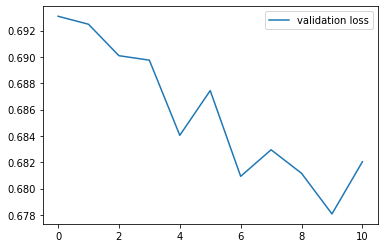

BEST VALIDATION ERROR THIS SESSION:  0.6780775259522831
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [11]  [ 0/17]  eta: 0:00:36  lr: 0.005000  loss: 0.6492 (0.6492)  loss_classifier: 0.1505 (0.1505)  loss_box_reg: 0.2467 (0.2467)  loss_mask: 0.2025 (0.2025)  loss_objectness: 0.0264 (0.0264)  loss_rpn_box_reg: 0.0231 (0.0231)  time: 2.1652  data: 0.5293  max mem: 9174
Epoch: [11]  [10/17]  eta: 0:00:10  lr: 0.005000  loss: 0.6530 (0.6670)  loss_classifier: 0.1453 (0.1522)  loss_box_reg: 0.2427 (0.2390)  loss_mask: 0.1990 (0.2134)  loss_objectness: 0.0216 (0.0239)  loss_rpn_box_reg: 0.0345 (0.0386)  time: 1.5597  data: 0.0625  max mem: 9174
Epoch: [11]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.6867 (0.7465)  loss_classifier: 0.1505 (0.1674)  loss_box_reg: 0.2747 (0.2777)  loss_mask: 0.2063 (0.2333)  loss_objectness: 0.0216 (0.0283)  loss_rpn_box_reg: 0.0345 (0.0398)  time: 1.5621  data: 0.0464  max mem: 9174
Epoch: [11] Total time: 0:00:26 (1.5680 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6877343198832344


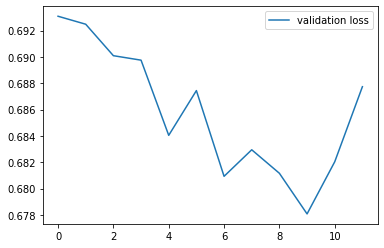

BEST VALIDATION ERROR THIS SESSION:  0.6780775259522831
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [12]  [ 0/17]  eta: 0:00:41  lr: 0.005000  loss: 0.8505 (0.8505)  loss_classifier: 0.1855 (0.1855)  loss_box_reg: 0.3334 (0.3334)  loss_mask: 0.2209 (0.2209)  loss_objectness: 0.0386 (0.0386)  loss_rpn_box_reg: 0.0721 (0.0721)  time: 2.4379  data: 0.8452  max mem: 9174
Epoch: [12]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.7000 (0.7191)  loss_classifier: 0.1579 (0.1626)  loss_box_reg: 0.2611 (0.2648)  loss_mask: 0.2221 (0.2244)  loss_objectness: 0.0305 (0.0300)  loss_rpn_box_reg: 0.0352 (0.0372)  time: 1.6064  data: 0.0876  max mem: 9174
Epoch: [12]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.7000 (0.7237)  loss_classifier: 0.1625 (0.1668)  loss_box_reg: 0.2716 (0.2672)  loss_mask: 0.2234 (0.2247)  loss_objectness: 0.0270 (0.0289)  loss_rpn_box_reg: 0.0315 (0.0361)  time: 1.5728  data: 0.0622  max mem: 9174
Epoch: [12] Total time: 0:00:26 (1.5787 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6836718916893005


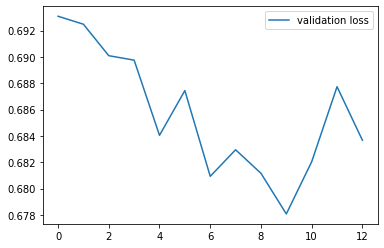

BEST VALIDATION ERROR THIS SESSION:  0.6780775259522831
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [13]  [ 0/17]  eta: 0:00:39  lr: 0.005000  loss: 0.6710 (0.6710)  loss_classifier: 0.1287 (0.1287)  loss_box_reg: 0.2914 (0.2914)  loss_mask: 0.1979 (0.1979)  loss_objectness: 0.0219 (0.0219)  loss_rpn_box_reg: 0.0311 (0.0311)  time: 2.2998  data: 0.6998  max mem: 9174
Epoch: [13]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.6592 (0.6541)  loss_classifier: 0.1401 (0.1419)  loss_box_reg: 0.2352 (0.2489)  loss_mask: 0.2096 (0.2101)  loss_objectness: 0.0207 (0.0215)  loss_rpn_box_reg: 0.0303 (0.0316)  time: 1.5987  data: 0.0756  max mem: 9174
Epoch: [13]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.6458 (0.6568)  loss_classifier: 0.1368 (0.1397)  loss_box_reg: 0.2311 (0.2409)  loss_mask: 0.2095 (0.2073)  loss_objectness: 0.0207 (0.0270)  loss_rpn_box_reg: 0.0324 (0.0419)  time: 1.5674  data: 0.0544  max mem: 9174
Epoch: [13] Total time: 0:00:26 (1.5731 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6797176003456116


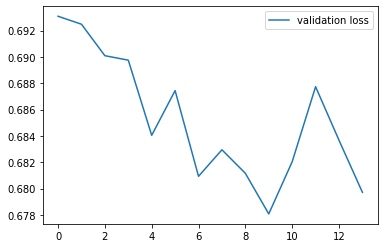

BEST VALIDATION ERROR THIS SESSION:  0.6780775259522831
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [14]  [ 0/17]  eta: 0:00:34  lr: 0.005000  loss: 0.4651 (0.4651)  loss_classifier: 0.0822 (0.0822)  loss_box_reg: 0.1267 (0.1267)  loss_mask: 0.2131 (0.2131)  loss_objectness: 0.0186 (0.0186)  loss_rpn_box_reg: 0.0244 (0.0244)  time: 2.0001  data: 0.5334  max mem: 9174
Epoch: [14]  [10/17]  eta: 0:00:10  lr: 0.005000  loss: 0.5779 (0.5747)  loss_classifier: 0.1172 (0.1191)  loss_box_reg: 0.2340 (0.2162)  loss_mask: 0.1989 (0.1883)  loss_objectness: 0.0199 (0.0202)  loss_rpn_box_reg: 0.0310 (0.0309)  time: 1.5681  data: 0.0631  max mem: 9174
Epoch: [14]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.5798 (0.5856)  loss_classifier: 0.1193 (0.1241)  loss_box_reg: 0.2346 (0.2257)  loss_mask: 0.1947 (0.1847)  loss_objectness: 0.0186 (0.0187)  loss_rpn_box_reg: 0.0268 (0.0324)  time: 1.5612  data: 0.0467  max mem: 9174
Epoch: [14] Total time: 0:00:26 (1.5670 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6753015307819142


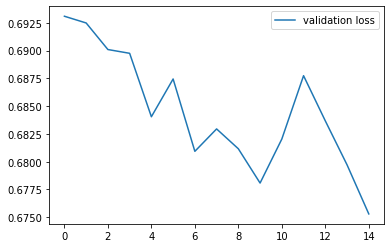

BEST VALIDATION ERROR THIS SESSION:  0.6753015307819142
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [15]  [ 0/17]  eta: 0:00:41  lr: 0.005000  loss: 0.3724 (0.3724)  loss_classifier: 0.0728 (0.0728)  loss_box_reg: 0.1473 (0.1473)  loss_mask: 0.1312 (0.1312)  loss_objectness: 0.0052 (0.0052)  loss_rpn_box_reg: 0.0158 (0.0158)  time: 2.4139  data: 0.8440  max mem: 9174
Epoch: [15]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.5884 (0.5978)  loss_classifier: 0.1269 (0.1239)  loss_box_reg: 0.2418 (0.2328)  loss_mask: 0.1803 (0.1797)  loss_objectness: 0.0183 (0.0263)  loss_rpn_box_reg: 0.0231 (0.0350)  time: 1.6101  data: 0.0879  max mem: 9174
Epoch: [15]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.5695 (0.5888)  loss_classifier: 0.1160 (0.1249)  loss_box_reg: 0.2119 (0.2292)  loss_mask: 0.1803 (0.1778)  loss_objectness: 0.0184 (0.0247)  loss_rpn_box_reg: 0.0225 (0.0322)  time: 1.5778  data: 0.0626  max mem: 9174
Epoch: [15] Total time: 0:00:26 (1.5835 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6757633195203894


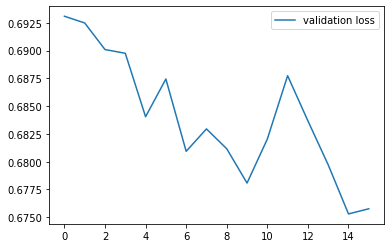

BEST VALIDATION ERROR THIS SESSION:  0.6753015307819142
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [16]  [ 0/17]  eta: 0:00:39  lr: 0.005000  loss: 0.9795 (0.9795)  loss_classifier: 0.1508 (0.1508)  loss_box_reg: 0.2297 (0.2297)  loss_mask: 0.1556 (0.1556)  loss_objectness: 0.1181 (0.1181)  loss_rpn_box_reg: 0.3253 (0.3253)  time: 2.3432  data: 0.7294  max mem: 9174
Epoch: [16]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.5818 (0.6331)  loss_classifier: 0.1251 (0.1293)  loss_box_reg: 0.1949 (0.2248)  loss_mask: 0.1614 (0.1798)  loss_objectness: 0.0263 (0.0405)  loss_rpn_box_reg: 0.0279 (0.0587)  time: 1.6110  data: 0.0798  max mem: 9174
Epoch: [16]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.6617 (0.6408)  loss_classifier: 0.1310 (0.1311)  loss_box_reg: 0.2383 (0.2341)  loss_mask: 0.1905 (0.1878)  loss_objectness: 0.0263 (0.0378)  loss_rpn_box_reg: 0.0279 (0.0501)  time: 1.5781  data: 0.0572  max mem: 9174
Epoch: [16] Total time: 0:00:26 (1.5845 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6724659239544588


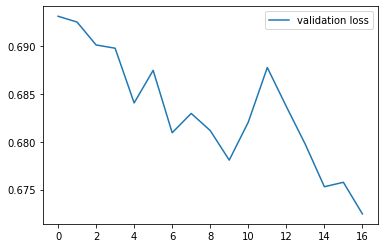

BEST VALIDATION ERROR THIS SESSION:  0.6724659239544588
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [17]  [ 0/17]  eta: 0:00:40  lr: 0.005000  loss: 0.6693 (0.6693)  loss_classifier: 0.1479 (0.1479)  loss_box_reg: 0.2786 (0.2786)  loss_mask: 0.1497 (0.1497)  loss_objectness: 0.0552 (0.0552)  loss_rpn_box_reg: 0.0379 (0.0379)  time: 2.3575  data: 0.7535  max mem: 9174
Epoch: [17]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.5981 (0.5798)  loss_classifier: 0.1341 (0.1316)  loss_box_reg: 0.2185 (0.2154)  loss_mask: 0.1677 (0.1760)  loss_objectness: 0.0203 (0.0214)  loss_rpn_box_reg: 0.0304 (0.0354)  time: 1.6016  data: 0.0809  max mem: 9174
Epoch: [17]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.5416 (0.5647)  loss_classifier: 0.1164 (0.1247)  loss_box_reg: 0.2071 (0.2126)  loss_mask: 0.1623 (0.1744)  loss_objectness: 0.0171 (0.0196)  loss_rpn_box_reg: 0.0304 (0.0335)  time: 1.5805  data: 0.0583  max mem: 9174
Epoch: [17] Total time: 0:00:26 (1.5867 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6740743763306561


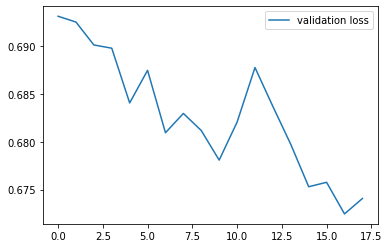

BEST VALIDATION ERROR THIS SESSION:  0.6724659239544588
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [18]  [ 0/17]  eta: 0:00:40  lr: 0.005000  loss: 0.3277 (0.3277)  loss_classifier: 0.0654 (0.0654)  loss_box_reg: 0.1406 (0.1406)  loss_mask: 0.1020 (0.1020)  loss_objectness: 0.0082 (0.0082)  loss_rpn_box_reg: 0.0115 (0.0115)  time: 2.3886  data: 0.8116  max mem: 9174
Epoch: [18]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.5374 (0.5453)  loss_classifier: 0.1261 (0.1211)  loss_box_reg: 0.2036 (0.2076)  loss_mask: 0.1634 (0.1709)  loss_objectness: 0.0176 (0.0198)  loss_rpn_box_reg: 0.0304 (0.0258)  time: 1.6100  data: 0.0875  max mem: 9174
Epoch: [18]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.5405 (0.5654)  loss_classifier: 0.1261 (0.1227)  loss_box_reg: 0.2060 (0.2135)  loss_mask: 0.1702 (0.1730)  loss_objectness: 0.0181 (0.0223)  loss_rpn_box_reg: 0.0316 (0.0339)  time: 1.5846  data: 0.0622  max mem: 9174
Epoch: [18] Total time: 0:00:27 (1.5909 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6762205467504614


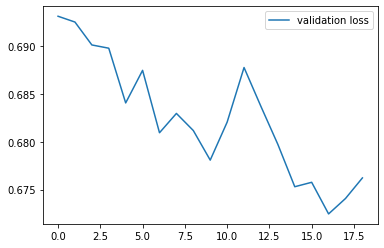

BEST VALIDATION ERROR THIS SESSION:  0.6724659239544588
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [19]  [ 0/17]  eta: 0:00:39  lr: 0.005000  loss: 0.4942 (0.4942)  loss_classifier: 0.1054 (0.1054)  loss_box_reg: 0.1589 (0.1589)  loss_mask: 0.1837 (0.1837)  loss_objectness: 0.0127 (0.0127)  loss_rpn_box_reg: 0.0334 (0.0334)  time: 2.3417  data: 0.8439  max mem: 9174
Epoch: [19]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.5409 (0.5836)  loss_classifier: 0.1054 (0.1237)  loss_box_reg: 0.2249 (0.2154)  loss_mask: 0.1838 (0.1911)  loss_objectness: 0.0187 (0.0269)  loss_rpn_box_reg: 0.0206 (0.0265)  time: 1.6065  data: 0.0904  max mem: 9174
Epoch: [19]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.5361 (0.5664)  loss_classifier: 0.1107 (0.1274)  loss_box_reg: 0.2074 (0.2120)  loss_mask: 0.1723 (0.1795)  loss_objectness: 0.0187 (0.0227)  loss_rpn_box_reg: 0.0217 (0.0247)  time: 1.5917  data: 0.0647  max mem: 9174
Epoch: [19] Total time: 0:00:27 (1.5975 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6770013114985298


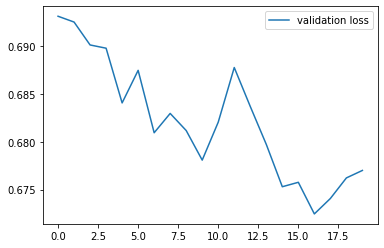

BEST VALIDATION ERROR THIS SESSION:  0.6724659239544588
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [20]  [ 0/17]  eta: 0:00:38  lr: 0.005000  loss: 0.3502 (0.3502)  loss_classifier: 0.0684 (0.0684)  loss_box_reg: 0.1198 (0.1198)  loss_mask: 0.1454 (0.1454)  loss_objectness: 0.0113 (0.0113)  loss_rpn_box_reg: 0.0053 (0.0053)  time: 2.2679  data: 0.6734  max mem: 9174
Epoch: [20]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.5039 (0.5194)  loss_classifier: 0.1041 (0.1146)  loss_box_reg: 0.1850 (0.2000)  loss_mask: 0.1478 (0.1603)  loss_objectness: 0.0167 (0.0208)  loss_rpn_box_reg: 0.0256 (0.0238)  time: 1.6043  data: 0.0767  max mem: 9174
Epoch: [20]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4575 (0.5285)  loss_classifier: 0.0981 (0.1131)  loss_box_reg: 0.1850 (0.2020)  loss_mask: 0.1478 (0.1617)  loss_objectness: 0.0167 (0.0196)  loss_rpn_box_reg: 0.0219 (0.0321)  time: 1.5766  data: 0.0553  max mem: 9174
Epoch: [20] Total time: 0:00:26 (1.5825 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6753970419659334


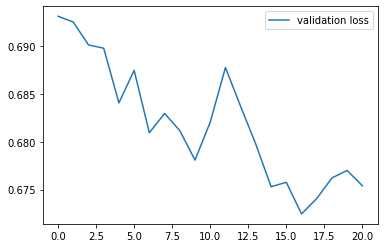

BEST VALIDATION ERROR THIS SESSION:  0.6724659239544588
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [21]  [ 0/17]  eta: 0:00:40  lr: 0.005000  loss: 0.5178 (0.5178)  loss_classifier: 0.1026 (0.1026)  loss_box_reg: 0.2276 (0.2276)  loss_mask: 0.1645 (0.1645)  loss_objectness: 0.0083 (0.0083)  loss_rpn_box_reg: 0.0149 (0.0149)  time: 2.3567  data: 0.7807  max mem: 9174
Epoch: [21]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.6388 (0.6014)  loss_classifier: 0.1494 (0.1329)  loss_box_reg: 0.2318 (0.2327)  loss_mask: 0.1746 (0.1784)  loss_objectness: 0.0149 (0.0222)  loss_rpn_box_reg: 0.0185 (0.0352)  time: 1.6139  data: 0.0837  max mem: 9174
Epoch: [21]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.5918 (0.5784)  loss_classifier: 0.1309 (0.1264)  loss_box_reg: 0.2274 (0.2226)  loss_mask: 0.1746 (0.1747)  loss_objectness: 0.0187 (0.0209)  loss_rpn_box_reg: 0.0245 (0.0338)  time: 1.5806  data: 0.0599  max mem: 9174
Epoch: [21] Total time: 0:00:26 (1.5864 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6751591528163237


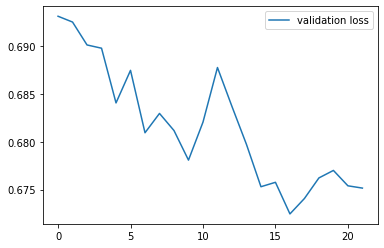

BEST VALIDATION ERROR THIS SESSION:  0.6724659239544588
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [22]  [ 0/17]  eta: 0:00:36  lr: 0.005000  loss: 0.5151 (0.5151)  loss_classifier: 0.0898 (0.0898)  loss_box_reg: 0.1704 (0.1704)  loss_mask: 0.2015 (0.2015)  loss_objectness: 0.0281 (0.0281)  loss_rpn_box_reg: 0.0254 (0.0254)  time: 2.1498  data: 0.6824  max mem: 9174
Epoch: [22]  [10/17]  eta: 0:00:10  lr: 0.005000  loss: 0.5248 (0.5810)  loss_classifier: 0.1132 (0.1178)  loss_box_reg: 0.1979 (0.2044)  loss_mask: 0.1740 (0.1799)  loss_objectness: 0.0211 (0.0322)  loss_rpn_box_reg: 0.0295 (0.0466)  time: 1.5690  data: 0.0740  max mem: 9174
Epoch: [22]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.5151 (0.5502)  loss_classifier: 0.1124 (0.1153)  loss_box_reg: 0.1970 (0.1995)  loss_mask: 0.1548 (0.1696)  loss_objectness: 0.0202 (0.0281)  loss_rpn_box_reg: 0.0254 (0.0377)  time: 1.5657  data: 0.0535  max mem: 9174
Epoch: [22] Total time: 0:00:26 (1.5718 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6729539878228131


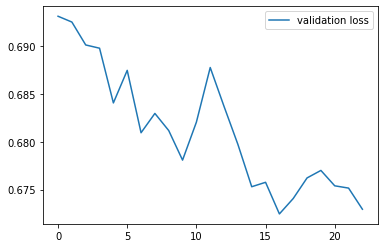

BEST VALIDATION ERROR THIS SESSION:  0.6724659239544588
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [23]  [ 0/17]  eta: 0:00:38  lr: 0.005000  loss: 0.3779 (0.3779)  loss_classifier: 0.0831 (0.0831)  loss_box_reg: 0.1358 (0.1358)  loss_mask: 0.1344 (0.1344)  loss_objectness: 0.0080 (0.0080)  loss_rpn_box_reg: 0.0167 (0.0167)  time: 2.2512  data: 0.6255  max mem: 9174
Epoch: [23]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.4283 (0.4818)  loss_classifier: 0.0979 (0.1046)  loss_box_reg: 0.1716 (0.1741)  loss_mask: 0.1442 (0.1492)  loss_objectness: 0.0088 (0.0167)  loss_rpn_box_reg: 0.0177 (0.0372)  time: 1.6230  data: 0.0716  max mem: 9174
Epoch: [23]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4517 (0.4933)  loss_classifier: 0.1005 (0.1074)  loss_box_reg: 0.1716 (0.1786)  loss_mask: 0.1506 (0.1573)  loss_objectness: 0.0105 (0.0159)  loss_rpn_box_reg: 0.0177 (0.0342)  time: 1.5817  data: 0.0520  max mem: 9174
Epoch: [23] Total time: 0:00:26 (1.5876 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6720647215843201


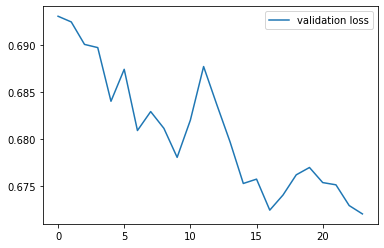

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [24]  [ 0/17]  eta: 0:00:39  lr: 0.005000  loss: 0.4212 (0.4212)  loss_classifier: 0.0715 (0.0715)  loss_box_reg: 0.1749 (0.1749)  loss_mask: 0.1271 (0.1271)  loss_objectness: 0.0199 (0.0199)  loss_rpn_box_reg: 0.0279 (0.0279)  time: 2.3212  data: 0.7086  max mem: 9174
Epoch: [24]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.5519 (0.5294)  loss_classifier: 0.1190 (0.1130)  loss_box_reg: 0.1976 (0.1954)  loss_mask: 0.1755 (0.1641)  loss_objectness: 0.0134 (0.0150)  loss_rpn_box_reg: 0.0279 (0.0418)  time: 1.6080  data: 0.0769  max mem: 9174
Epoch: [24]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4747 (0.5179)  loss_classifier: 0.1101 (0.1054)  loss_box_reg: 0.1856 (0.1891)  loss_mask: 0.1753 (0.1637)  loss_objectness: 0.0134 (0.0214)  loss_rpn_box_reg: 0.0279 (0.0383)  time: 1.5760  data: 0.0553  max mem: 9174
Epoch: [24] Total time: 0:00:26 (1.5818 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.676640650805305


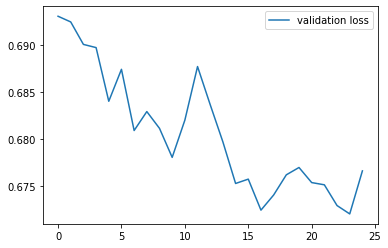

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [25]  [ 0/17]  eta: 0:00:39  lr: 0.005000  loss: 0.7469 (0.7469)  loss_classifier: 0.1974 (0.1974)  loss_box_reg: 0.3047 (0.3047)  loss_mask: 0.1839 (0.1839)  loss_objectness: 0.0218 (0.0218)  loss_rpn_box_reg: 0.0392 (0.0392)  time: 2.3484  data: 0.7628  max mem: 9174
Epoch: [25]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.5083 (0.5197)  loss_classifier: 0.1048 (0.1062)  loss_box_reg: 0.1989 (0.1922)  loss_mask: 0.1702 (0.1715)  loss_objectness: 0.0177 (0.0177)  loss_rpn_box_reg: 0.0321 (0.0321)  time: 1.5922  data: 0.0834  max mem: 9174
Epoch: [25]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.5083 (0.5077)  loss_classifier: 0.1048 (0.1030)  loss_box_reg: 0.1991 (0.1912)  loss_mask: 0.1683 (0.1651)  loss_objectness: 0.0161 (0.0185)  loss_rpn_box_reg: 0.0241 (0.0298)  time: 1.5749  data: 0.0601  max mem: 9174
Epoch: [25] Total time: 0:00:26 (1.5809 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6731244991807377


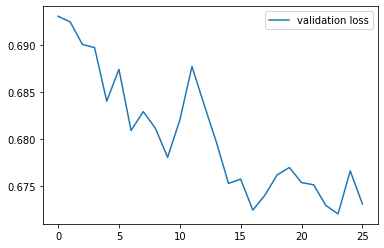

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [26]  [ 0/17]  eta: 0:00:37  lr: 0.005000  loss: 0.4984 (0.4984)  loss_classifier: 0.0854 (0.0854)  loss_box_reg: 0.1600 (0.1600)  loss_mask: 0.1703 (0.1703)  loss_objectness: 0.0541 (0.0541)  loss_rpn_box_reg: 0.0285 (0.0285)  time: 2.2230  data: 0.6528  max mem: 9174
Epoch: [26]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.4693 (0.4640)  loss_classifier: 0.0905 (0.0956)  loss_box_reg: 0.1739 (0.1744)  loss_mask: 0.1441 (0.1530)  loss_objectness: 0.0105 (0.0175)  loss_rpn_box_reg: 0.0234 (0.0235)  time: 1.6032  data: 0.0737  max mem: 9174
Epoch: [26]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4324 (0.4748)  loss_classifier: 0.0905 (0.0983)  loss_box_reg: 0.1739 (0.1806)  loss_mask: 0.1441 (0.1536)  loss_objectness: 0.0105 (0.0170)  loss_rpn_box_reg: 0.0234 (0.0253)  time: 1.5823  data: 0.0536  max mem: 9174
Epoch: [26] Total time: 0:00:26 (1.5882 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6746095068314496


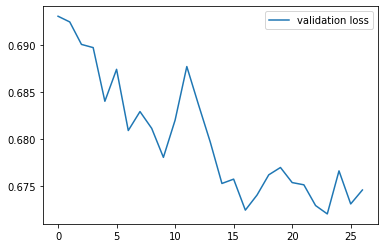

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [27]  [ 0/17]  eta: 0:00:41  lr: 0.005000  loss: 0.5716 (0.5716)  loss_classifier: 0.1198 (0.1198)  loss_box_reg: 0.2391 (0.2391)  loss_mask: 0.1520 (0.1520)  loss_objectness: 0.0277 (0.0277)  loss_rpn_box_reg: 0.0331 (0.0331)  time: 2.4497  data: 0.7696  max mem: 9174
Epoch: [27]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.4710 (0.4730)  loss_classifier: 0.1050 (0.0972)  loss_box_reg: 0.1950 (0.1858)  loss_mask: 0.1520 (0.1510)  loss_objectness: 0.0122 (0.0145)  loss_rpn_box_reg: 0.0240 (0.0247)  time: 1.6246  data: 0.0854  max mem: 9174
Epoch: [27]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4676 (0.4573)  loss_classifier: 0.0982 (0.0982)  loss_box_reg: 0.1621 (0.1774)  loss_mask: 0.1403 (0.1457)  loss_objectness: 0.0115 (0.0140)  loss_rpn_box_reg: 0.0211 (0.0221)  time: 1.5966  data: 0.0614  max mem: 9174
Epoch: [27] Total time: 0:00:27 (1.6027 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6768480539321899


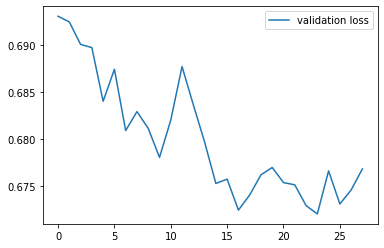

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [28]  [ 0/17]  eta: 0:00:41  lr: 0.005000  loss: 0.3936 (0.3936)  loss_classifier: 0.0923 (0.0923)  loss_box_reg: 0.1457 (0.1457)  loss_mask: 0.1275 (0.1275)  loss_objectness: 0.0106 (0.0106)  loss_rpn_box_reg: 0.0175 (0.0175)  time: 2.4176  data: 0.8157  max mem: 9174
Epoch: [28]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.4036 (0.4393)  loss_classifier: 0.0810 (0.0933)  loss_box_reg: 0.1527 (0.1650)  loss_mask: 0.1463 (0.1505)  loss_objectness: 0.0106 (0.0109)  loss_rpn_box_reg: 0.0185 (0.0197)  time: 1.6153  data: 0.0887  max mem: 9174
Epoch: [28]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4047 (0.4527)  loss_classifier: 0.0918 (0.0976)  loss_box_reg: 0.1663 (0.1683)  loss_mask: 0.1471 (0.1530)  loss_objectness: 0.0106 (0.0123)  loss_rpn_box_reg: 0.0194 (0.0215)  time: 1.5907  data: 0.0632  max mem: 9174
Epoch: [28] Total time: 0:00:27 (1.5970 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6738000512123108


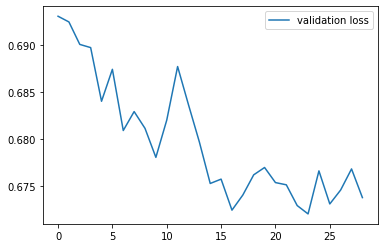

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [29]  [ 0/17]  eta: 0:00:39  lr: 0.005000  loss: 0.5454 (0.5454)  loss_classifier: 0.1327 (0.1327)  loss_box_reg: 0.2148 (0.2148)  loss_mask: 0.1610 (0.1610)  loss_objectness: 0.0144 (0.0144)  loss_rpn_box_reg: 0.0225 (0.0225)  time: 2.3073  data: 0.6678  max mem: 9174
Epoch: [29]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.4473 (0.4616)  loss_classifier: 0.0924 (0.0946)  loss_box_reg: 0.1566 (0.1712)  loss_mask: 0.1400 (0.1432)  loss_objectness: 0.0110 (0.0174)  loss_rpn_box_reg: 0.0264 (0.0352)  time: 1.6258  data: 0.0741  max mem: 9174
Epoch: [29]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4473 (0.4652)  loss_classifier: 0.0920 (0.0905)  loss_box_reg: 0.1608 (0.1701)  loss_mask: 0.1458 (0.1445)  loss_objectness: 0.0136 (0.0216)  loss_rpn_box_reg: 0.0264 (0.0385)  time: 1.5892  data: 0.0538  max mem: 9174
Epoch: [29] Total time: 0:00:27 (1.5956 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6722080882857827


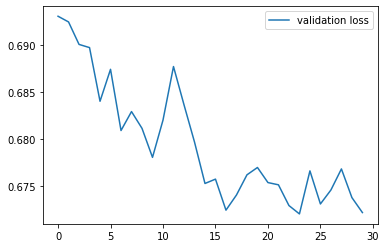

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [30]  [ 0/17]  eta: 0:00:41  lr: 0.005000  loss: 0.3737 (0.3737)  loss_classifier: 0.0643 (0.0643)  loss_box_reg: 0.1572 (0.1572)  loss_mask: 0.1287 (0.1287)  loss_objectness: 0.0088 (0.0088)  loss_rpn_box_reg: 0.0146 (0.0146)  time: 2.4637  data: 0.8499  max mem: 9174
Epoch: [30]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.4336 (0.4396)  loss_classifier: 0.0961 (0.0928)  loss_box_reg: 0.1600 (0.1598)  loss_mask: 0.1385 (0.1384)  loss_objectness: 0.0179 (0.0217)  loss_rpn_box_reg: 0.0233 (0.0268)  time: 1.6321  data: 0.1014  max mem: 9174
Epoch: [30]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4290 (0.4467)  loss_classifier: 0.0836 (0.0927)  loss_box_reg: 0.1664 (0.1665)  loss_mask: 0.1402 (0.1421)  loss_objectness: 0.0125 (0.0190)  loss_rpn_box_reg: 0.0172 (0.0265)  time: 1.6036  data: 0.0714  max mem: 9174
Epoch: [30] Total time: 0:00:27 (1.6098 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6742274691076839


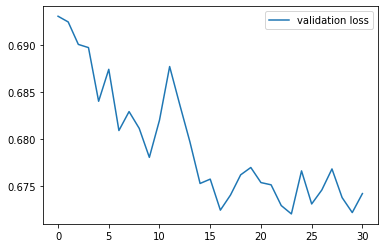

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [31]  [ 0/17]  eta: 0:00:42  lr: 0.005000  loss: 0.3835 (0.3835)  loss_classifier: 0.0589 (0.0589)  loss_box_reg: 0.1600 (0.1600)  loss_mask: 0.1461 (0.1461)  loss_objectness: 0.0053 (0.0053)  loss_rpn_box_reg: 0.0132 (0.0132)  time: 2.5208  data: 0.9486  max mem: 9174
Epoch: [31]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.4413 (0.4599)  loss_classifier: 0.0916 (0.0919)  loss_box_reg: 0.1698 (0.1721)  loss_mask: 0.1673 (0.1566)  loss_objectness: 0.0126 (0.0167)  loss_rpn_box_reg: 0.0183 (0.0227)  time: 1.6174  data: 0.0972  max mem: 9174
Epoch: [31]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4392 (0.4602)  loss_classifier: 0.0900 (0.0960)  loss_box_reg: 0.1619 (0.1696)  loss_mask: 0.1461 (0.1528)  loss_objectness: 0.0126 (0.0177)  loss_rpn_box_reg: 0.0183 (0.0240)  time: 1.5994  data: 0.0689  max mem: 9174
Epoch: [31] Total time: 0:00:27 (1.6054 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6800079065210679


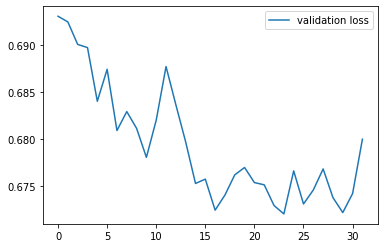

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [32]  [ 0/17]  eta: 0:00:41  lr: 0.005000  loss: 0.4894 (0.4894)  loss_classifier: 0.0844 (0.0844)  loss_box_reg: 0.1774 (0.1774)  loss_mask: 0.1710 (0.1710)  loss_objectness: 0.0113 (0.0113)  loss_rpn_box_reg: 0.0452 (0.0452)  time: 2.4395  data: 0.8028  max mem: 9174
Epoch: [32]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.4072 (0.4195)  loss_classifier: 0.0844 (0.0846)  loss_box_reg: 0.1467 (0.1587)  loss_mask: 0.1438 (0.1419)  loss_objectness: 0.0113 (0.0125)  loss_rpn_box_reg: 0.0191 (0.0219)  time: 1.6106  data: 0.0839  max mem: 9174
Epoch: [32]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4554 (0.4510)  loss_classifier: 0.0844 (0.0907)  loss_box_reg: 0.1467 (0.1664)  loss_mask: 0.1442 (0.1495)  loss_objectness: 0.0113 (0.0196)  loss_rpn_box_reg: 0.0205 (0.0249)  time: 1.5812  data: 0.0602  max mem: 9174
Epoch: [32] Total time: 0:00:26 (1.5874 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6757997169214136


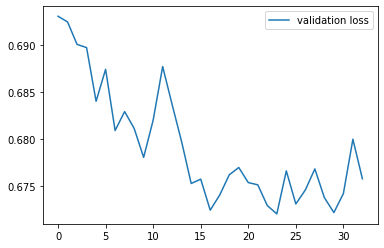

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [33]  [ 0/17]  eta: 0:00:36  lr: 0.005000  loss: 0.4979 (0.4979)  loss_classifier: 0.1066 (0.1066)  loss_box_reg: 0.1771 (0.1771)  loss_mask: 0.1784 (0.1784)  loss_objectness: 0.0155 (0.0155)  loss_rpn_box_reg: 0.0203 (0.0203)  time: 2.1674  data: 0.5653  max mem: 9174
Epoch: [33]  [10/17]  eta: 0:00:10  lr: 0.005000  loss: 0.4149 (0.4413)  loss_classifier: 0.0887 (0.0915)  loss_box_reg: 0.1585 (0.1623)  loss_mask: 0.1444 (0.1482)  loss_objectness: 0.0131 (0.0133)  loss_rpn_box_reg: 0.0203 (0.0259)  time: 1.5704  data: 0.0666  max mem: 9174
Epoch: [33]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4240 (0.4495)  loss_classifier: 0.0887 (0.0948)  loss_box_reg: 0.1585 (0.1607)  loss_mask: 0.1444 (0.1495)  loss_objectness: 0.0148 (0.0182)  loss_rpn_box_reg: 0.0209 (0.0263)  time: 1.5587  data: 0.0492  max mem: 9174
Epoch: [33] Total time: 0:00:26 (1.5648 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6752761321909287


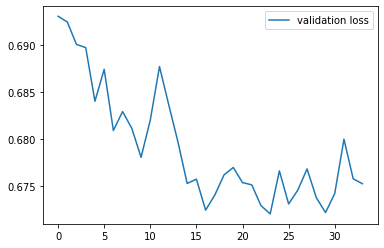

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [34]  [ 0/17]  eta: 0:00:38  lr: 0.005000  loss: 0.5857 (0.5857)  loss_classifier: 0.1151 (0.1151)  loss_box_reg: 0.2451 (0.2451)  loss_mask: 0.1852 (0.1852)  loss_objectness: 0.0095 (0.0095)  loss_rpn_box_reg: 0.0307 (0.0307)  time: 2.2612  data: 0.6662  max mem: 9174
Epoch: [34]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.4625 (0.4777)  loss_classifier: 0.0879 (0.0994)  loss_box_reg: 0.1725 (0.1771)  loss_mask: 0.1609 (0.1569)  loss_objectness: 0.0150 (0.0143)  loss_rpn_box_reg: 0.0194 (0.0300)  time: 1.6045  data: 0.0757  max mem: 9174
Epoch: [34]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4625 (0.4736)  loss_classifier: 0.0879 (0.0965)  loss_box_reg: 0.1685 (0.1734)  loss_mask: 0.1559 (0.1525)  loss_objectness: 0.0158 (0.0206)  loss_rpn_box_reg: 0.0232 (0.0306)  time: 1.5790  data: 0.0551  max mem: 9174
Epoch: [34] Total time: 0:00:26 (1.5852 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6772001876550562


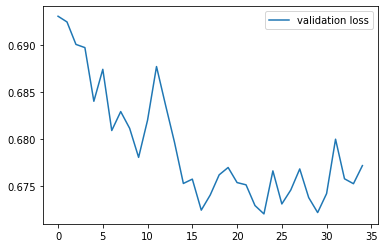

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [35]  [ 0/17]  eta: 0:00:41  lr: 0.005000  loss: 0.3900 (0.3900)  loss_classifier: 0.0769 (0.0769)  loss_box_reg: 0.1693 (0.1693)  loss_mask: 0.1234 (0.1234)  loss_objectness: 0.0076 (0.0076)  loss_rpn_box_reg: 0.0128 (0.0128)  time: 2.4530  data: 0.8659  max mem: 9174
Epoch: [35]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.3978 (0.4118)  loss_classifier: 0.0900 (0.0892)  loss_box_reg: 0.1581 (0.1501)  loss_mask: 0.1341 (0.1354)  loss_objectness: 0.0115 (0.0148)  loss_rpn_box_reg: 0.0232 (0.0223)  time: 1.6156  data: 0.0899  max mem: 9174
Epoch: [35]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4366 (0.4328)  loss_classifier: 0.0912 (0.0923)  loss_box_reg: 0.1693 (0.1622)  loss_mask: 0.1364 (0.1395)  loss_objectness: 0.0117 (0.0143)  loss_rpn_box_reg: 0.0242 (0.0246)  time: 1.5930  data: 0.0639  max mem: 9174
Epoch: [35] Total time: 0:00:27 (1.5990 s / it)
##### CURRENT VAL LOSS ON MASKS #####: 0.6745453371721155


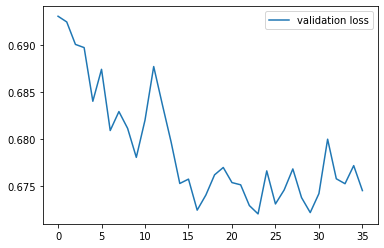

BEST VALIDATION ERROR THIS SESSION:  0.6720647215843201
BEST ALL TIME VALIDATION ERROR:  0.5444630086421967


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [36]  [ 0/17]  eta: 0:00:40  lr: 0.005000  loss: 0.3804 (0.3804)  loss_classifier: 0.0866 (0.0866)  loss_box_reg: 0.1429 (0.1429)  loss_mask: 0.1317 (0.1317)  loss_objectness: 0.0066 (0.0066)  loss_rpn_box_reg: 0.0126 (0.0126)  time: 2.4025  data: 0.8847  max mem: 9174
Epoch: [36]  [10/17]  eta: 0:00:11  lr: 0.005000  loss: 0.4077 (0.4320)  loss_classifier: 0.0866 (0.0908)  loss_box_reg: 0.1599 (0.1599)  loss_mask: 0.1452 (0.1394)  loss_objectness: 0.0116 (0.0169)  loss_rpn_box_reg: 0.0226 (0.0249)  time: 1.6107  data: 0.0914  max mem: 9174
Epoch: [36]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 0.4077 (0.4240)  loss_classifier: 0.0866 (0.0870)  loss_box_reg: 0.1599 (0.1605)  loss_mask: 0.1452 (0.1395)  loss_objectness: 0.0118 (0.0150)  loss_rpn_box_reg: 0.0193 (0.0220)  time: 1.5914  data: 0.0651  max mem: 9174
Epoch: [36] Total time: 0:00:27 (1.5976 s / it)


KeyboardInterrupt: ignored

time: 18min 41s


In [ ]:
# let's train it for some epochs
val_error_mean = []
epochs = []
all_time_best_val = torch.load(model_path + "alltimebest.pt") 
current_best_val = np.inf

for epoch in range(num_epochs):
    curr_epoch = epoch
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    # update the learning rate
    #lr_scheduler.step()
    # evaluate the model on prediction capability on masks only
    val_errors = []
    model.eval()
    for i in range(dataset_val_.__len__()):

      img, target = dataset_val_.__getitem__(i)

      # Predict
      prediction = model([img.to(device)])[0]

      # Create one mask from the multiple masks in pred_masks
      # either sum or mean the predicted masks 
      pred_mask_ = tensor_to_binary((sum(tensor_to_binary(prediction["masks"]))))
      #pred_mask_ = torch.mean(prediction["masks"], axis = 0)
      
      # Get target mask
      target_mask = torch.sum(target["masks"], axis = 0).to(device) # tensor
      target_mask = target_mask.reshape(1,target_mask.shape[0], target_mask.shape[1]).float()

      # Compute loss
      loss = criterion(pred_mask_, target_mask)
      val_errors = np.append(val_errors, get_numpy(loss.data)) 

    # plot loss
    epochs = np.append(epochs, epoch)
    val_error_mean = np.append(val_error_mean, np.mean(val_errors))
    print("##### CURRENT VAL LOSS ON MASKS #####:", val_error_mean[-1])
    # Plot training and validation errors
    plt.subplot()
    plt.plot(epochs, val_error_mean, label='validation loss')
    plt.legend()
    plt.show()

    # Check if better than all time best
    gg = 0
    if val_error_mean[-1] < all_time_best_val:
      torch.save(val_error_mean[-1], model_path + "alltimebest.pt")
      torch.save(model.state_dict(), model_path + "maskRCNN.pt")
      all_time_best_val = val_error_mean[-1]
      gg = 1
    else:
      None

    # Check if better than current best
    if val_error_mean[-1] < current_best_val:
      current_best_val = val_error_mean[-1]
      current_best_val_epoch = curr_epoch
    else:
      None

    # Print
    print("BEST VALIDATION ERROR THIS SESSION: ", current_best_val)
    print("BEST ALL TIME VALIDATION ERROR: ", all_time_best_val)

    if gg == 1:
      print("NEW ALL TIME BEST!")
      wp = 1
    else:
      None

## $\color{purple}{\text{Looking at a random observation from validation set}}$

In [ ]:
# pick an image from the last validation set
rand_idx = random.choice(range(0, dataset_val_.__len__()))
img, target = dataset_val_[rand_idx]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

time: 250 ms


In [ ]:
# Get final one channel binary prediction mask in numpy
final_mask = tensor_to_binary((sum(tensor_to_binary(prediction[0]["masks"]))))

np_final_mask = get_numpy(final_mask)
np_final_mask = np_final_mask.reshape(np_final_mask.shape[1],np_final_mask.shape[2])

# Get original image
img = get_numpy(img)
img = img.reshape(img.shape[1],img.shape[2],img.shape[0])

# Get original mask in numpy
org_mask = sum(target["masks"])
org_mask = get_numpy(org_mask)

time: 19.8 ms


Text(0.5, 1.0, 'original mask and bounding boxes')

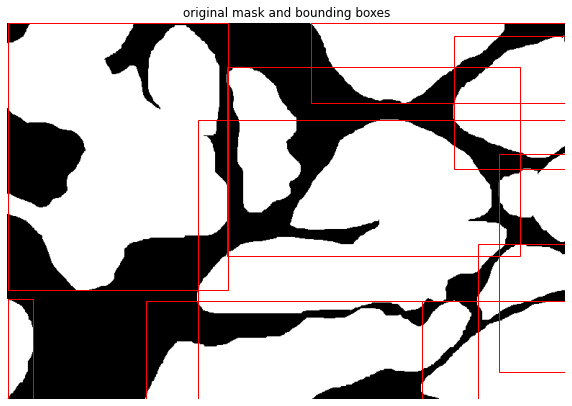

time: 185 ms


In [ ]:
# Visualize augmented image and bbox
fig, ax = plt.subplots(1, figsize = (10, 8))

# Plot the original image and bounding box
ax.axis('off')
ax.imshow(org_mask, cmap="gray")

for bboxes in target["boxes"]:

  bboxes = get_numpy(bboxes)

  rect = patches.Rectangle((bboxes[0],bboxes[1]), bboxes[2], bboxes[3],linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

ax.set_title('original mask and bounding boxes')

Text(0.5, 1.0, 'predicted mask and bounding boxes')

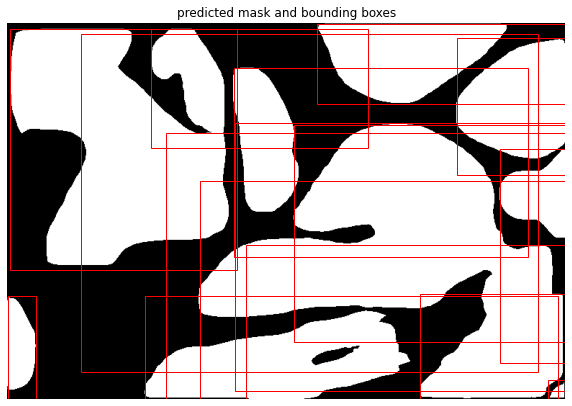

time: 189 ms


In [ ]:
fig, ax = plt.subplots(1, figsize = (10, 8))

ax.axis('off')
ax.imshow(np_final_mask, cmap="gray")

for bboxes in prediction[0]["boxes"]:

  bboxes = get_numpy(bboxes)

  rect = patches.Rectangle((bboxes[0],bboxes[1]), bboxes[2], bboxes[3],linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

ax.set_title('predicted mask and bounding boxes')

In [ ]:
np_final_mask.shape

(522, 775)

time: 1.92 ms


 # $\color{orange}{\text{Evaluation / Testing}}$

 ## $\color{purple}{\text{Functions}}$

### 1. Test loop

In [ ]:
def test(dataset, model):
  model.eval()
  test_error = []
  count = []
  f1 = []
  f1_obj = []
  hausdorff_obj_distance = []
  criterion = torch.nn.BCEWithLogitsLoss()
  #criterion = torch.nn.BCELoss()
  with torch.no_grad():

    for i in range(0, dataset.__len__()):
    
      # Get image and target
      img, target = dataset.__getitem__(i)
      
      # Predict
      prediction = model([img.to(device)])[0]

      # Create one mask from the multiple masks in pred_masks
      # make each individual mask binary and the total mask binary
      pred_mask_ = tensor_to_binary((sum(tensor_to_binary(prediction["masks"]))))

      # Get target mask
      target_mask = sum(target["masks"]).to(device) # tensor
      target_mask = target_mask.reshape(1,target_mask.shape[0], target_mask.shape[1]).float()
        
      # Compute loss
      loss = criterion(pred_mask_, target_mask)
      test_error = np.append(test_error, get_numpy(loss.data)) 

      # Prepare images for metrics
      metric_mask = np.uint8(pred_mask_.cpu().detach().numpy()).reshape(pred_mask_.shape[1], pred_mask_.shape[2])
      metric_target = np.uint8(target_mask.cpu().numpy()).reshape(target_mask.shape[1], target_mask.shape[2])
        
      # Get metrics
      metrics = BinaryImageMetrics(metric_target, metric_mask)

      # Calculate metrics 
      count = np.append(count, metrics.get_count())
      f1 = np.append(f1, metrics.get_f1())
      f1_obj = np.append(f1_obj, metrics.get_f1_obj())
      hausdorff_obj_distance = np.append(hausdorff_obj_distance, metrics.get_hausdorff_obj_distance())

      if 60%(i+1) == 0:
        print("Testing: ", i+1,"/", dataset.__len__())
    
    # Plot Results
    plt.figure(figsize=(10,5))
    plt.plot(range(len(test_error)), test_error, label='Test Error')
    plt.hlines(np.mean(test_error), 0, dataset.__len__(), label='average')
    plt.legend()
    plt.title('Test Error')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(range(len(count)), count, label = 'Count')
    plt.hlines(np.mean(count), 0, dataset.__len__(), label='average')
    plt.legend()
    plt.title('Count Metric')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(range(len(f1)), f1, label = 'F1')
    plt.hlines(np.mean(f1), 0, dataset.__len__(), label='average')
    plt.legend()
    plt.title('F1 Metric')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(range(len(f1_obj)), f1_obj, label = 'F1 Object')
    plt.hlines(np.mean(f1_obj), 0, dataset.__len__(), label='average')
    plt.legend()
    plt.title('F1 Object Metric')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(range(len(hausdorff_obj_distance)), hausdorff_obj_distance, label = 'Hausdorff Object Distance')
    plt.hlines(np.mean(hausdorff_obj_distance), 0, dataset.__len__(), label='average')
    plt.legend()
    plt.title('Hausdorff Object Distance')
    plt.show()

    # Values for return
    count = np.mean(count)
    f1 = np.mean(f1)
    f1_obj = np.mean(f1_obj)
    haus = np.mean(hausdorff_obj_distance)

    return test_error, count, f1, f1_obj, haus

time: 96.9 ms


### 2. Show best prediction

In [ ]:
def prediction_best(test_error, dataset, model):
  # Get data
  min_error_index = np.argmin(test_error)
  image, target = dataset.__getitem__(min_error_index)

  # Get prediction
  prediction = model([image.to(device)])[0]
  best_pred_mask = tensor_to_binary((sum(tensor_to_binary(prediction["masks"])))).cpu().detach().numpy()
  original_mask = sum(target["masks"])

  # Print predicted and original

  print('Original Image index')
  org_idx = get_numpy(target["image_id"])
  print("Index:", org_idx)

  
  print('Predicted Mask')
  fig, ax = plt.subplots(1, figsize = (6, 6))

  plt.imshow(best_pred_mask.reshape(best_pred_mask.shape[1], best_pred_mask.shape[2]), cmap = 'gray')
  
  for bboxes in prediction["boxes"]:
    
    bboxes = get_numpy(bboxes)
    rect = patches.Rectangle((bboxes[0],bboxes[1]), bboxes[2], bboxes[3],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  plt.axis('off')
  plt.show()

  print('Original Mask')
  fig, ax = plt.subplots(1, figsize = (6, 6))
  plt.imshow(original_mask, cmap = 'gray')

  for bboxes in target["boxes"]:
    
    bboxes = get_numpy(bboxes)
    rect = patches.Rectangle((bboxes[0],bboxes[1]), bboxes[2], bboxes[3],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  plt.axis('off')
  plt.show()


time: 29.7 ms


### 3. Show average prediction

In [ ]:
def prediction_avg(test_error, dataset, net):
  # Get data
  avg_error_index = find_nearest(test_error, np.mean(test_error))
  image, target = dataset.__getitem__(avg_error_index)

  # Get prediction
  prediction = model([image.to(device)])[0]
  avg_pred_mask = tensor_to_binary((sum(tensor_to_binary(prediction["masks"])))).cpu().detach().numpy()
  original_mask = sum(target["masks"])

  print('Original Image index')
  org_idx = get_numpy(target["image_id"])
  print("Index:", org_idx)
  
  # Print predicted and original
  print('Predicted Mask')
  fig, ax = plt.subplots(1, figsize = (6, 6))
  plt.imshow(avg_pred_mask.reshape(avg_pred_mask.shape[1], avg_pred_mask.shape[2]),cmap = 'gray')

  for bboxes in prediction["boxes"]:
    
    bboxes = get_numpy(bboxes)
    rect = patches.Rectangle((bboxes[0],bboxes[1]), bboxes[2], bboxes[3],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  plt.axis('off')
  plt.show()

  print('Original Mask')
  fig, ax = plt.subplots(1, figsize = (6, 6))
  plt.imshow(original_mask, cmap = 'gray')

  for bboxes in target["boxes"]:
    
    bboxes = get_numpy(bboxes)
    rect = patches.Rectangle((bboxes[0],bboxes[1]), bboxes[2], bboxes[3],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  plt.axis('off')
  plt.show()

time: 24.7 ms


### 4. Show worst prediction

In [ ]:
def prediction_worst(test_error, dataset, net):
  # Get data
  max_error_index = np.argmax(test_error)
  image, target = dataset.__getitem__(max_error_index)

  # Get prediction
  prediction = model([image.to(device)])[0]
  worst_pred_mask = tensor_to_binary((sum(tensor_to_binary(prediction["masks"])))).cpu().detach().numpy()
  original_mask = sum(target["masks"])

  print('Original Image index')
  org_idx = get_numpy(target["image_id"])
  print("Index:", org_idx)

  # Print predicted and original
  print('Predicted Mask')
  fig, ax = plt.subplots(1, figsize = (6, 6))
  plt.imshow(worst_pred_mask.reshape(worst_pred_mask.shape[1], worst_pred_mask.shape[2]),cmap = 'gray')
  
  for bboxes in prediction["boxes"]:
    
    bboxes = get_numpy(bboxes)
    rect = patches.Rectangle((bboxes[0],bboxes[1]), bboxes[2], bboxes[3],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  plt.axis('off')
  plt.show()

  print('Original Mask')
  fig, ax = plt.subplots(1, figsize = (6, 6))
  plt.imshow(original_mask, cmap = 'gray')

  for bboxes in target["boxes"]:
    
    bboxes = get_numpy(bboxes)
    rect = patches.Rectangle((bboxes[0],bboxes[1]), bboxes[2], bboxes[3],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  plt.axis('off')
  plt.show()


time: 34.6 ms


### 5. Benchmark

In [ ]:
def benchmark_results(unet, maskrcnn):

  # Input data from paper
  comparison = {'F1_A_SCORE' : [0.912, 0.891, 0.896, 0.870, 0.868, 0.892, 0.834, 0.652, 0.777, 0.635, np.nan, np.nan],
                'F1_A_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                'F1_B_SCORE' : [0.716, 0.703, 0.719, 0.695, 0.769, 0.686, 0.605, 0.541, 0.306, 0.527, np.nan, np.nan],
                'F1_B_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                'F1_OBJ_A_SCORE' : [0.897, 0.882, 0.886, 0.876, 0.867, 0.884, 0.875, 0.644, 0.781, 0.737, np.nan, np.nan],
                'F1_OBJ_A_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                'F1_OBJ_B_SCORE' : [0.781, 0.786, 0.765, 0.786, 0.800, 0.754, 0.783, 0.654, 0.617, 0.610, np.nan, np.nan],
                'F1_OBJ_B_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                'HAUS_A_SCORE' : [45.418, 57.413, 57.350, 57.093, 74.596, 54.785, 57.194, 155.433, 112.706, 107.491, np.nan, np.nan],
                'HAUS_A_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                'HAUS_B_SCORE' : [160.347, 145.575, 159.873, 148.463, 153.646, 187.442, 146.607, 176.244, 190.447, 210.105, np.nan, np.nan],
                'HAUS_B_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
               }

  comparison = pd.DataFrame(comparison, index = ["CUMedVision2", "ExB1", "ExB3", "Freiburg2", "CUMedVision1", "ExB2", "Freiburg1", "CVML", "LIB", "vision4GlaS", "DTU-UNET", "DTU-MASKRCNN"])

  # Add Unet data
  comparison.loc['DTU-UNET', 'F1_A_SCORE'] = unet[0]
  comparison.loc['DTU-UNET', 'F1_B_SCORE'] = unet[1]
  comparison.loc['DTU-UNET', 'F1_OBJ_A_SCORE'] = unet[2]
  comparison.loc['DTU-UNET', 'F1_OBJ_B_SCORE'] = unet[3]
  comparison.loc['DTU-UNET', 'HAUS_A_SCORE'] = unet[4]
  comparison.loc['DTU-UNET', 'HAUS_B_SCORE'] = unet[5]

  # Add Maskrcnn data
  comparison.loc['DTU-MASKRCNN', 'F1_A_SCORE'] = maskrcnn[0]
  comparison.loc['DTU-MASKRCNN', 'F1_B_SCORE'] = maskrcnn[1]
  comparison.loc['DTU-MASKRCNN', 'F1_OBJ_A_SCORE'] = maskrcnn[2]
  comparison.loc['DTU-MASKRCNN', 'F1_OBJ_B_SCORE'] = maskrcnn[3]
  comparison.loc['DTU-MASKRCNN', 'HAUS_A_SCORE'] = maskrcnn[4]
  comparison.loc['DTU-MASKRCNN', 'HAUS_B_SCORE'] = maskrcnn[5]

  # Assign ranks
  # F1 A
  comparison = comparison.sort_values(by = 'F1_A_SCORE', ascending = False)
  i = 1
  for index, row in comparison.iterrows():
    row['F1_A_RANK'] = i
    i += 1
  # F1 B
  comparison = comparison.sort_values(by = 'F1_B_SCORE', ascending = False)
  i = 1
  for index, row in comparison.iterrows():
    row['F1_B_RANK'] = i
    i += 1
  # F1_OBJ A
  comparison = comparison.sort_values(by = 'F1_OBJ_A_SCORE', ascending = False)
  i = 1
  for index, row in comparison.iterrows():
    row['F1_OBJ_A_RANK'] = i
    i += 1
  # F1_OBJ B
  comparison = comparison.sort_values(by = 'F1_OBJ_B_SCORE', ascending = False)
  i = 1
  for index, row in comparison.iterrows():
    row['F1_OBJ_B_RANK'] = i
    i += 1
  # HAUS A
  comparison = comparison.sort_values(by = 'HAUS_A_SCORE', ascending = True)
  i = 1
  for index, row in comparison.iterrows():
    row['HAUS_A_RANK'] = i
    i += 1
  # HAUS B
  comparison = comparison.sort_values(by = 'HAUS_B_SCORE', ascending = True)
  i = 1
  for index, row in comparison.iterrows():
    row['HAUS_B_RANK'] = i
    i += 1
  # Summary
  comparison['FINAL_RANK'] = comparison['F1_A_RANK'] + comparison['F1_B_RANK'] + comparison['F1_OBJ_A_RANK'] + comparison['F1_OBJ_B_RANK'] + comparison['HAUS_A_RANK'] + comparison['HAUS_B_RANK']
  comparison = comparison.sort_values(by = 'FINAL_RANK', ascending = True)

  return comparison


time: 122 ms


 ## $\color{purple}{\text{Execute}}$

### Testset A 

Testing:  1 / 60
Testing:  2 / 60
Testing:  3 / 60
Testing:  4 / 60
Testing:  5 / 60
Testing:  6 / 60
Testing:  10 / 60
Testing:  12 / 60
Testing:  15 / 60
Testing:  20 / 60
Testing:  30 / 60
Testing:  60 / 60


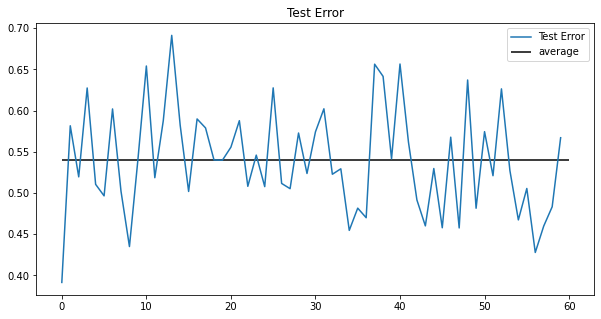

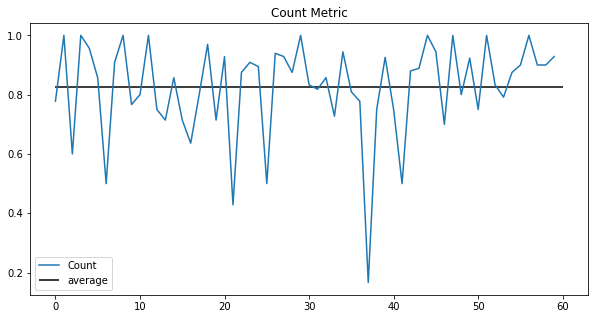

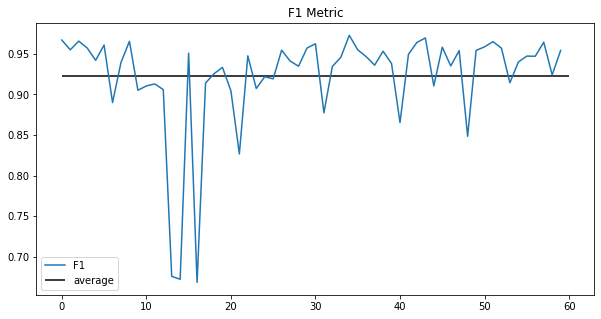

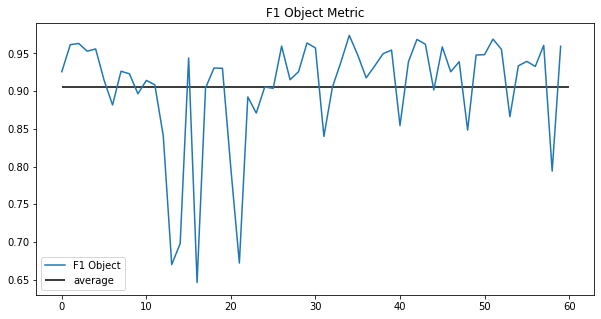

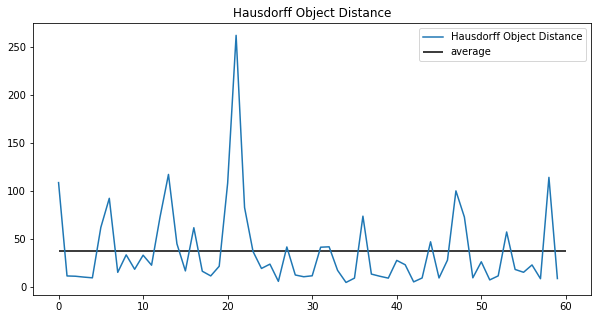

time: 1min 21s


In [ ]:
test_error_A, count_A, f1_A, f1_obj_A, haus_A = test(dataset_testA, model)

Original Image index
Index: [0]
Predicted Mask


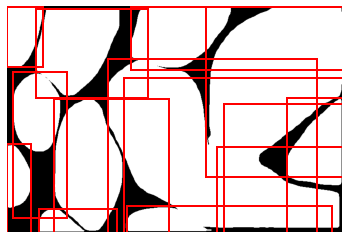

Original Mask


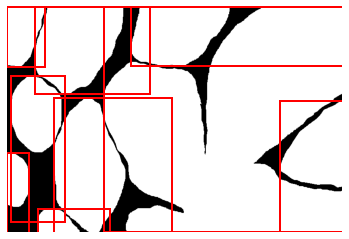

time: 379 ms


In [ ]:
prediction_best(test_error_A, dataset_testA, model)

Original image


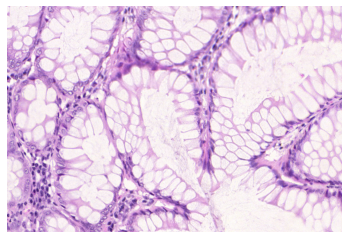

time: 150 ms


In [ ]:
print("Original image")
fig, ax = plt.subplots(1, figsize = (6, 6))
plt.imshow(imread(testA[0][1]))
plt.axis("off")
plt.show()

Original Image index
Index: [19]
Predicted Mask


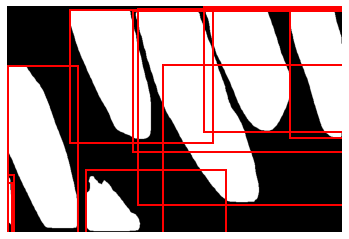

Original Mask


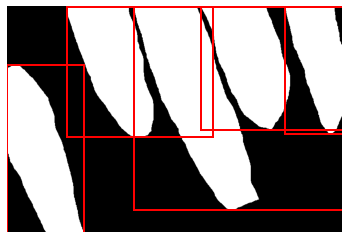

time: 391 ms


In [ ]:
prediction_avg(test_error_A, dataset_testA, model)

Original image


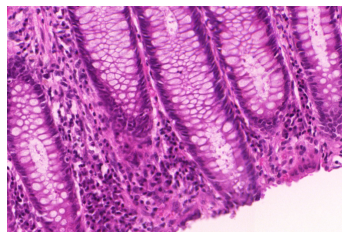

time: 151 ms


In [ ]:
print("Original image")
fig, ax = plt.subplots(1, figsize = (6, 6))
plt.imshow(imread(testA[19][1]))
plt.axis("off")
plt.show()

Original Image index
Index: [13]
Predicted Mask


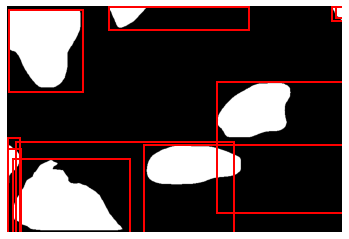

Original Mask


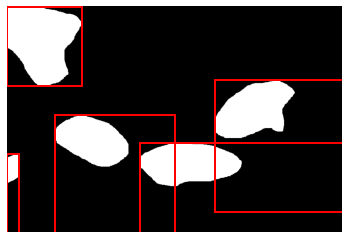

time: 353 ms


In [ ]:
prediction_worst(test_error_A, dataset_testA, model)

Original image


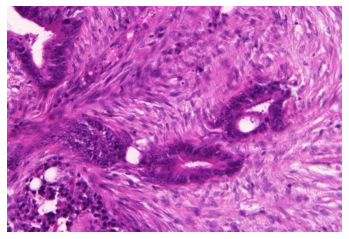

time: 138 ms


In [ ]:
print("Original image")
fig, ax = plt.subplots(1, figsize = (6, 6))
plt.imshow(imread(testA[13][1]))
plt.axis("off")
plt.show()

### Testset B

Testing:  1 / 20
Testing:  2 / 20
Testing:  3 / 20
Testing:  4 / 20
Testing:  5 / 20
Testing:  6 / 20
Testing:  10 / 20
Testing:  12 / 20
Testing:  15 / 20
Testing:  20 / 20


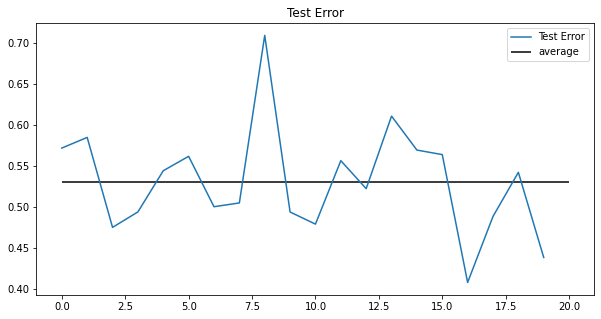

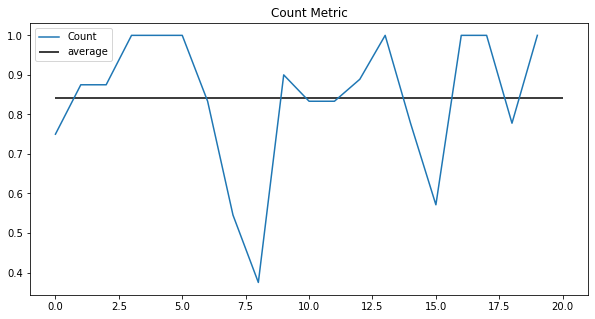

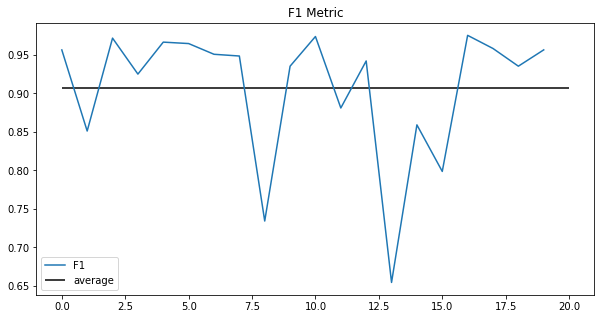

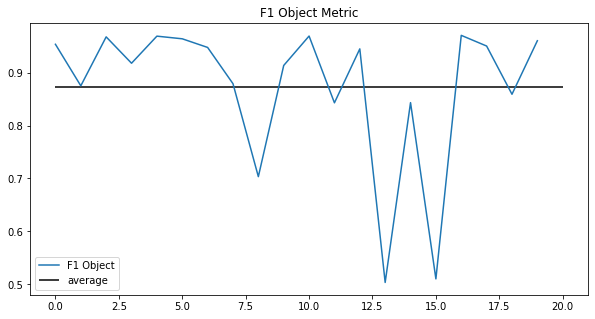

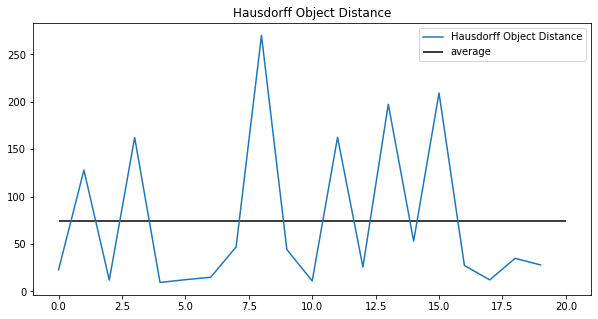

time: 36.4 s


In [ ]:
test_error_B, count_B, f1_B, f1_obj_B, haus_B = test(dataset_testB, model)

Original Image index
Index: [16]
Predicted Mask


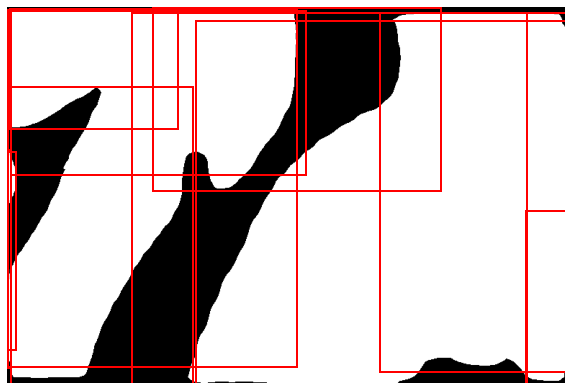

Original Mask


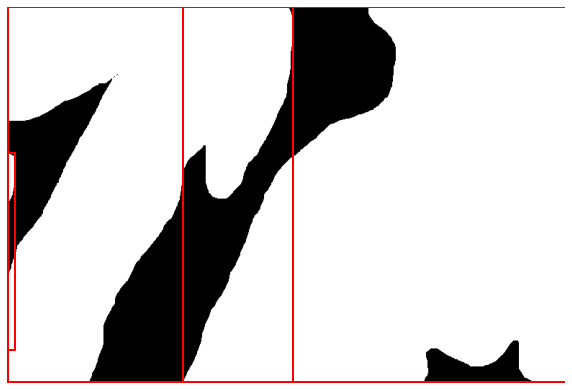

time: 423 ms


In [ ]:
prediction_best(test_error_B, dataset_testB, model)

Original image


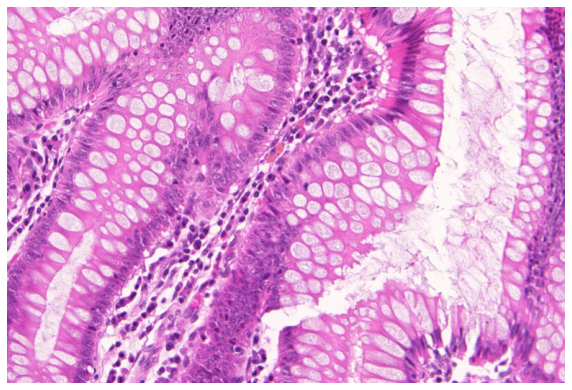

time: 252 ms


In [ ]:
print("Original image")
fig, ax = plt.subplots(1, figsize = (10, 8))
plt.imshow(imread(testB[16][1]))
plt.axis("off")
plt.show()

Original Image index
Index: [12]
Predicted Mask


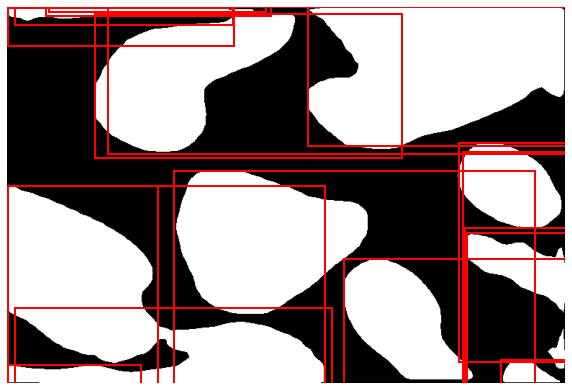

Original Mask


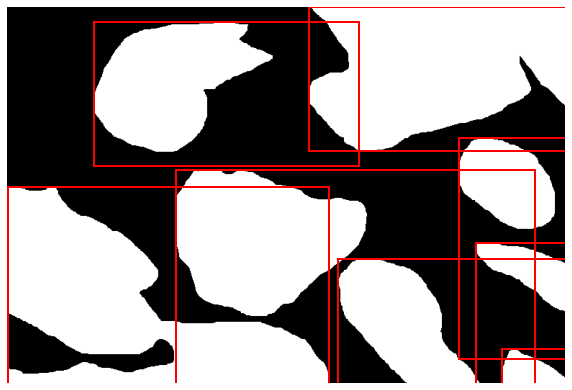

time: 461 ms


In [ ]:
prediction_avg(test_error_B, dataset_testB, model)

Original image


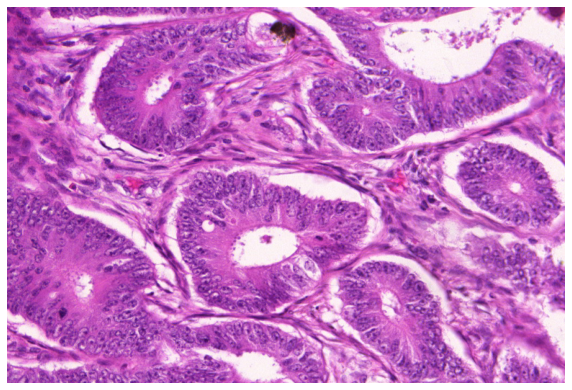

time: 235 ms


In [ ]:
print("Original image")
fig, ax = plt.subplots(1, figsize = (10, 8))
plt.imshow(imread(testB[12][1]))
plt.axis("off")
plt.show()

Original Image index
Index: [8]
Predicted Mask


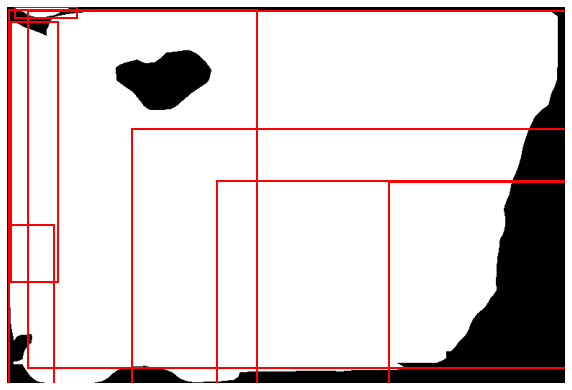

Original Mask


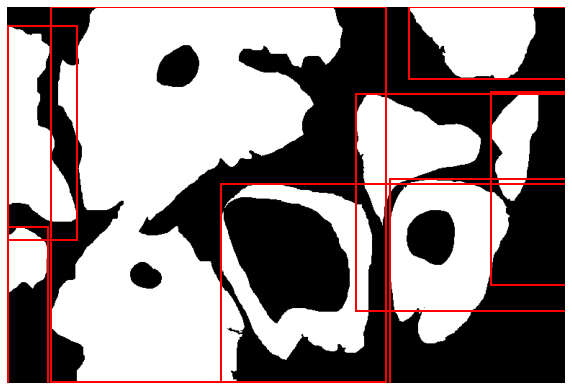

time: 424 ms


In [ ]:
prediction_worst(test_error_B, dataset_testB, model)

Original image


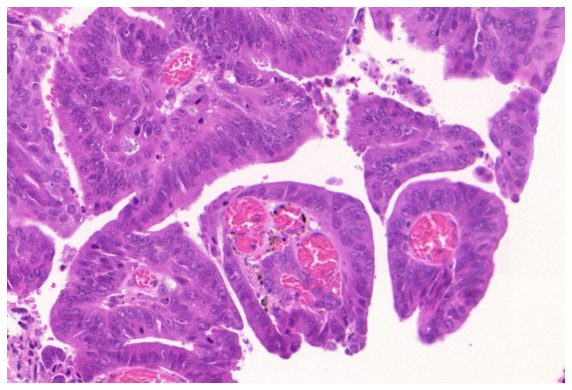

time: 267 ms


In [ ]:
print("Original image")
fig, ax = plt.subplots(1, figsize = (10, 8))
plt.imshow(imread(testB[8][1]))
plt.axis("off")
plt.show()

### Benchmark

In [ ]:
benchmark_results(unet = [0, 0, 0, 0, 0, 0], maskrcnn = [f1_A, f1_B, f1_obj_A, f1_obj_B, haus_A, haus_B])

F1_A_SCORE  F1_A_RANK  ...  HAUS_B_RANK  FINAL_RANK
DTU-MASKRCNN    0.922217        1.0  ...          2.0         8.0
CUMedVision2    0.912000        2.0  ...          8.0        25.0
ExB1            0.891000        5.0  ...          3.0        29.0
ExB3            0.896000        3.0  ...          7.0        30.0
Freiburg2       0.870000        6.0  ...          5.0        32.0
CUMedVision1    0.868000        7.0  ...          6.0        34.0
ExB2            0.892000        4.0  ...         10.0        37.0
Freiburg1       0.834000        8.0  ...          4.0        38.0
DTU-UNET        0.000000       12.0  ...          1.0        50.0
CVML            0.652000       10.0  ...          9.0        60.0
LIB             0.777000        9.0  ...         11.0        61.0
vision4GlaS     0.635000       11.0  ...         12.0        64.0

[12 rows x 13 columns]

time: 56.5 ms


In [ ]:
print("TestA:",count_A)
print("TestB:",count_B)
print("TestA error:", np.mean(test_error_A))
print("TestB error:", np.mean(test_error_B))

TestA: 0.8246241262904115
TestB: 0.8418163780663781
TestA error: 0.5394603977600734
TestB error: 0.5307886987924576
time: 3.01 ms
